## Analyze TriOS Data

Uncertainty, comparing to TSG, and 

In [1]:
import xarray as xr
import numpy as np

import hvplot.xarray


import cartopy.crs as crs

import pandas as pd
import geopandas as gpd

import glob
import hvplot.pandas  # noqa
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv("data/ivan_cruise/SW21009R_NRL/EventData/DataLogger/Data every 1 min_001.elg")
df.head()

Date      Time  SW-ZDA-Year  SW-ZDA-Month  SW-ZDA-Day  SW-ZDA-Time  \
0  08/25/2021  12:46:24         2021             8          25    124935.70   
1  08/25/2021  12:47:25         2021             8          25    125035.70   
2  08/25/2021  12:48:25         2021             8          25    125135.70   
3  08/25/2021  12:49:25         2021             8          25    125235.69   
4  08/25/2021  12:50:25         2021             8          25    125336.69   

   SW-GGA-Lat SW-GGA-NorS  SW-GGA-Long SW-GGA-EorW  ...  \
0   3433.3240           N    7610.8499           W  ...   
1   3433.4081           N    7610.6764           W  ...   
2   3433.4919           N    7610.5111           W  ...   
3   3433.5739           N    7610.3362           W  ...   
4   3433.6615           N    7610.1648           W  ...   

   SW-Weather-HumidRel-%  SW-Wind-WindSpeedRel  SW-Wind-WindAngleRel  \
0                   76.1                  5.00                 76.40   
1                   75.7                  4.49                 86.89   
2                   75.2                  3.29                 95.20   
3                   75.6                  5.29                 80.90   
4                   75.3                  2.90                 99.29   

   TrueWind-DRV-SPEED  TrueWind-DRV-DIRECTION  TSG--temp-SBE38  TSG--sal  \
0               10.75                  219.05          27.7042   35.6590   
1               12.15                  215.33          27.6905   35.6585   
2               11.20                  214.90          27.6949   35.6639   
3               12.10                  213.94          27.6968   35.6928   
4               11.44                  221.88          27.6971   35.6891   

   SW-Depth-DBT-Depth below transducer (m)  DepthOverall-DRV-VALUE  \
0                                    36.91                   37.88   
1                                    37.36                   38.36   
2                                    37.80                   38.80   
3                                    36.98                   37.98   
4                                    36.95                   37.95   

   Unnamed: 24  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN  

[5 rows x 25 columns]

In [3]:
len(df)

6859

In [4]:
# about 5 days
len(df) / 60 / 24

4.763194444444444

The ship's computer was about 4 minutes behind so adding that here. Will fix this by using the data stamped by the GPS clock.

In [5]:
date_time_strs = df['Date'] + ' ' + df['Time']

df['datetime'] = [datetime.strptime(x, '%m/%d/%Y %H:%M:%S') for x in date_time_strs]
df['utc_dt'] = df['datetime']+ timedelta(minutes=4)
df  = df.set_index('utc_dt')

Convert their format into the lat and lon format that is easier to work with in geopandas and python

In [6]:
def dms2dd(degrees, minutes, seconds, direction):
    dd = degrees + minutes/60 + seconds/(60*60);
    if direction == 'W' or direction == 'S':
        dd *= -1
    return dd;

df['lon'] = dms2dd(pd.to_numeric(df['SW-GGA-Long'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Long'].astype(str).str[2:]),np.array(0), 'W')
df['lat'] = dms2dd(pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[:2]).astype(float), pd.to_numeric(df['SW-GGA-Lat'].astype(str).str[2:]),np.array(0), 'E')

<AxesSubplot:>

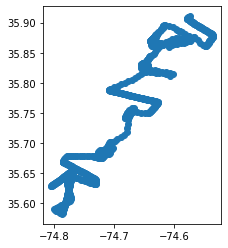

In [7]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.loc['2021-08-27 8:00:00':'2021-08-27 23:45:00'].plot()

In [8]:
df.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

In [9]:
cdom_files = [
    'data/ivan_cruise/cdom/cdom_flu_output_210825_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210826_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210827_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210828_1.txt',
    'data/ivan_cruise/cdom/cdom_flu_output_210829_1.txt'
             ]

cdom_dfs = []

for item in cdom_files:
    cdom_data = open(item)
    lines = cdom_data.readlines()
    sensor_values = []
    utc_times = []
    for i in range(len(lines)):
        line = lines[i]
        if "sensor" in line:
            try:
                line = line.split('= ')[1]
                line = line.replace('\n', '')
                sensor_values.append(int(line))
                if "UTC" in lines[i-1]:
                    data_time = lines[i-1][5:-2]
                    utc_times.append(data_time)
                elif "UTC" in lines[i+1]:
                    data_time = lines[i+1][5:-2]
                    utc_times.append(data_time)
            except:
                pass
    print(len(sensor_values)-len(utc_times))
    sensor_values = sensor_values[len(sensor_values)-len(utc_times):]
    utc_times = pd.to_datetime(utc_times)
    cdom_df = pd.DataFrame(np.array(sensor_values)/1024.0*5, columns = ['cdom_volts'])
    cdom_df['utc_dt'] = utc_times
    cdom_df  = cdom_df.set_index('utc_dt')
    cdom_dfs.append(cdom_df)
    
cdom_df = pd.DataFrame().append(cdom_dfs)

12
285
2
28
104


#### pull in the SST data from GOES

In [10]:
goes_ds = xr.open_dataset('data/jplStarG16SSTv270_8997_d932_2101.nc')

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/conventions.py:492: SerializationWarning: variable 'sea_surface_temperature' has multiple fill values {-327.67, -327.68}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


#### Pull in the TriOS radiometer data

In [11]:
trios_fns = [
    'data/ivan_cruise/trios/shearwater_trios_20210826.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210827.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210828.csv',
    'data/ivan_cruise/trios/shearwater_trios_20210829.csv',
            ]
trios_dfs = []
for fn in trios_fns:
    trios_dfs.append(pd.read_csv(fn))

trios_df = pd.DataFrame().append(trios_dfs)

Based on our notes I believe that the TriOS data was saved as local time so I convert it here to UTC. I have not included the offset compared to the inline but that is likely about 10 seconds or more.

In [12]:
trios_df['datetime'] = pd.to_datetime(trios_df['TimeStamp'])
trios_df['utc_dt'] =trios_df['datetime'] + timedelta(hours=4) # moving it to UTC
trios_df = trios_df.set_index('utc_dt')

<AxesSubplot:xlabel='utc_dt'>

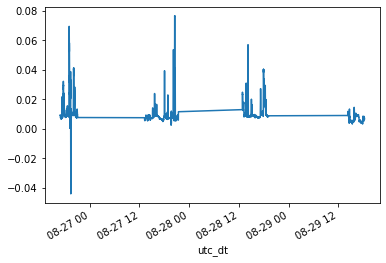

In [13]:
trios_df['400'].rolling(window=6*3).mean().plot()

In [14]:
# these are the coefficients based on the Hu et al 2012 paper

ci1 = -0.49
ci2 = 191.6590

# these are some coefficients that I calculated using the same exact method but trying to optimize for the Micasense bands

# ci1 = -0.38152295986028695
# ci2 = 271.37634868

# average of 443*.5 + 489*1.5
# ci1 = -0.30002281538304754
# ci2 = 310.5772338

# ci1 = -0.21380600002416383
# ci2 = 572.01573044



def oc_index(blue, green, red):
    blue, green, red = blue, green, red
    CI = green - ( blue + (555 - 477)/(667 - 477) * (red - blue) )
    ChlCI = 10**(ci1 + ci2*CI)
    return(ChlCI)

In [15]:
trios_df['chla_oci'] = oc_index(trios_df.iloc[:, 156:161].mean(axis=1).values, trios_df.iloc[:, 232:240].mean(axis=1).values, trios_df.iloc[:, 346:351].mean(axis=1).values)

Some of the values are way too high so cutting those off.

In [16]:
trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan

<ipython-input-16-07c79c7d9104>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trios_df['chla_oci'][trios_df['chla_oci'] > 1 ] = np.nan


(0.0, 0.4)

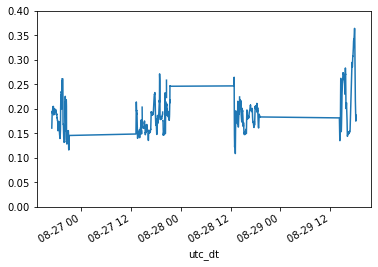

In [17]:
fig, ax = plt.subplots()
trios_df['chla_oci'].rolling(window=6*5).mean().plot(ax=ax)
ax.set_ylim(0,.4)

#### Filter all TriOS data for outliers and make dataset that is just the transects

In [18]:
start_times = ['2021-08-26 12:15:00', '2021-08-27 11:38:00', '2021-08-27 16:09:00', '2021-08-27 18:30:00', '2021-08-27 22:25:00', '2021-08-28 10:50:00',
               '2021-08-28 13:48:00', '2021-08-28 15:08:00', '2021-08-28 18:31:00', '2021-08-28 20:16:00', '2021-08-29 11:10:00', '2021-08-29 14:39:00',
               '2021-08-29 16:15:00']


end_times   = ['2021-08-26 14:12:00', '2021-08-27 12:52:00', '2021-08-27 17:40:00', '2021-08-27 18:45:00', '2021-08-27 23:35:00', '2021-08-28 12:05:00',
               '2021-08-28 14:05:00', '2021-08-28 16:48:00', '2021-08-28 18:56:00', '2021-08-28 21:50:00', '2021-08-29 13:40:00', '2021-08-29 15:00:00',
               '2021-08-29 17:52:00']

In [19]:
trios_transects = []
timestamps = []

for i in range(13):
    if trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*3).mean()['chla_oci'].empty:
        pass
    else:
        print(i)
        
        trios_df_transect = trios_df.loc[start_times[i]:end_times[i]]
        
        # Calculate rolling median and filter everything based on 440nm
        rolling_440 = trios_df_transect['440'].rolling(window=6*2).median()
        upper_threshold = 0.0005
        lower_threshold = -0.0005
        # filter based on threshold all in one line 
        df_filtered = trios_df_transect.drop(trios_df_transect[(trios_df_transect['440']-rolling_440>upper_threshold)|(trios_df_transect['440']- rolling_440<lower_threshold)].index) 

        trios_transects.append(df_filtered)
        timestamps.append(df_filtered['TimeStamp'])
        
trios_transects = pd.concat(trios_transects)

2
3
6
7
8
11
12


In [20]:
timestamps = [item for sublist in timestamps for item in sublist]

In [21]:
# subtract NIR from whole spectrum
corrected_specs = []
for i in range(len(trios_transects)):
    corrected_specs.append(trios_transects.iloc[i,1:-2] - trios_transects.iloc[i,450:480].mean())

corrected_specs = pd.DataFrame(corrected_specs, columns=df_filtered.columns[1:-2] )
corrected_specs['chla_oci'] = oc_index(corrected_specs.iloc[:, 156:161].mean(axis=1).values, corrected_specs.iloc[:, 232:240].mean(axis=1).values, corrected_specs.iloc[:, 346:351].mean(axis=1).values)
corrected_specs['TimeStamp'] = timestamps

lats = []
lons = []
sals = []
temps = []
for i in range(len(corrected_specs)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(corrected_specs.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    sals.append(row['TSG--sal'])
    temps.append(row['TSG--temp-SBE38'])
corrected_specs['lat'] = lats
corrected_specs['lon'] = lons
corrected_specs['sal'] = sals
corrected_specs['temp'] = temps

trios_gdf = gpd.GeoDataFrame(corrected_specs, geometry=gpd.points_from_xy(corrected_specs.lon, corrected_specs.lat))
        

In [22]:
corrected_specs.hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.05,tiles='EsriNatGeo')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [lon,lat]

### Pull in HPLC timings

In [23]:
hplc_df = pd.read_csv('data/ivan_cruise/hplc_timing.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'data/ivan_cruise/hplc_timing.csv'

In [29]:
hplc_df.head()

Sample  Date  Time (LST)  Volume (ml)                               Notes
0       1  26-8        1605          500          at the start of Ivan's dye
1       2  26-8        1605          500          at the start of Ivan's dye
2       3  26-8        1632          500         in the middle of the front?
3       4  27-8         742          500  starting transect on offshore side
4       5  27-8         811          500             in front - T&S changing

In [30]:
hplc_df['datetime'] = pd.to_datetime([datetime.strptime(x, '%Y %d-%m %H%M') for x in '2021 ' + hplc_df.Date + ' ' + hplc_df['Time (LST)'].astype(str)])
hplc_df['datetime']   = hplc_df['datetime'] + timedelta(hours=4) # moving it to UTC
hplc_df['utc_dt']   = hplc_df['datetime']
hplc_df = hplc_df.set_index('utc_dt')

In [81]:
start_times

['2021-08-26 12:15:00',
 '2021-08-27 11:38:00',
 '2021-08-27 16:09:00',
 '2021-08-27 18:30:00',
 '2021-08-27 22:25:00',
 '2021-08-28 10:50:00',
 '2021-08-28 13:48:00',
 '2021-08-28 15:08:00',
 '2021-08-28 18:31:00',
 '2021-08-28 20:16:00',
 '2021-08-29 11:10:00',
 '2021-08-29 14:39:00',
 '2021-08-29 16:15:00']

In [80]:
goes_ds.sea_surface_temperature[:,:, :].hvplot.quadmesh(
    'longitude', 'latitude', projection=crs.PlateCarree(), project=True,
    cmap='inferno', dynamic=True, 
    frame_height=600, clim=(25.5, 30), rasterize=True) * df.loc[start_times[i]:end_times[i]].hvplot.points('lon', 'lat', geo=True, color='red', alpha=0.01)

:DynamicMap   [time]
   :Overlay
      .Image.I  :Image   [longitude,latitude]   (sea_surface_temperature)
      .Points.I :Points   [lon,lat]

## Visualizing the subset of transects with potentially good radiometer data

In [31]:
plt.rcParams.update({'font.size': 14})

In [143]:
trios_subset.iloc[:,120:-315]

440       441       442       443       444  \
2021-08-29 16:15:10  0.006118  0.006082  0.006043  0.006001  0.005965   
2021-08-29 16:15:20  0.006892  0.006853  0.006812  0.006767  0.006728   
2021-08-29 16:15:30  0.006965  0.006927  0.006887  0.006842  0.006803   
2021-08-29 16:15:40  0.007050  0.007011  0.006971  0.006927  0.006889   
2021-08-29 16:15:50  0.006979  0.006939  0.006898  0.006854  0.006815   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002920  0.002931  0.002940  0.002949  0.002962   
2021-08-29 17:51:00  0.002922  0.002933  0.002941  0.002950  0.002962   
2021-08-29 17:51:30  0.002769  0.002783  0.002796  0.002808  0.002824   
2021-08-29 17:51:40  0.002699  0.002714  0.002728  0.002742  0.002758   
2021-08-29 17:52:00  0.003328  0.003333  0.003337  0.003340  0.003348   

                          445       446       447       448       449  ...  \
2021-08-29 16:15:10  0.005931  0.005910  0.005874  0.005838  0.005824  ...   
2021-08-29 16:15:20  0.006692  0.006670  0.006631  0.006593  0.006578  ...   
2021-08-29 16:15:30  0.006766  0.006744  0.006705  0.006667  0.006651  ...   
2021-08-29 16:15:40  0.006853  0.006831  0.006794  0.006757  0.006741  ...   
2021-08-29 16:15:50  0.006778  0.006755  0.006719  0.006683  0.006666  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002975  0.002995  0.003007  0.003019  0.003040  ...   
2021-08-29 17:51:00  0.002974  0.002993  0.003005  0.003016  0.003038  ...   
2021-08-29 17:51:30  0.002840  0.002863  0.002879  0.002895  0.002922  ...   
2021-08-29 17:51:40  0.002775  0.002797  0.002813  0.002829  0.002853  ...   
2021-08-29 17:52:00  0.003356  0.003372  0.003380  0.003388  0.003409  ...   

                          633       634       635       636       637  \
2021-08-29 16:15:10  0.000362  0.000365  0.000368  0.000370  0.000373   
2021-08-29 16:15:20  0.000422  0.000423  0.000423  0.000422  0.000423   
2021-08-29 16:15:30  0.000449  0.000451  0.000454  0.000454  0.000456   
2021-08-29 16:15:40  0.000377  0.000379  0.000380  0.000380  0.000381   
2021-08-29 16:15:50  0.000405  0.000407  0.000409  0.000410  0.000413   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.000589  0.000587  0.000586  0.000583  0.000581   
2021-08-29 17:51:00  0.000586  0.000584  0.000582  0.000580  0.000578   
2021-08-29 17:51:30  0.000581  0.000579  0.000577  0.000574  0.000573   
2021-08-29 17:51:40  0.000544  0.000542  0.000540  0.000537  0.000535   
2021-08-29 17:52:00  0.000636  0.000635  0.000634  0.000632  0.000632   

                          638       639       640       641       642  
2021-08-29 16:15:10  0.000376  0.000370  0.000364  0.000357  0.000350  
2021-08-29 16:15:20  0.000424  0.000417  0.000411  0.000407  0.000402  
2021-08-29 16:15:30  0.000459  0.000452  0.000445  0.000443  0.000439  
2021-08-29 16:15:40  0.000382  0.000377  0.000372  0.000371  0.000369  
2021-08-29 16:15:50  0.000416  0.000412  0.000405  0.000402  0.000398  
...                       ...       ...       ...       ...       ...  
2021-08-29 17:50:50  0.000580  0.000575  0.000567  0.000563  0.000559  
2021-08-29 17:51:00  0.000577  0.000573  0.000566  0.000562  0.000558  
2021-08-29 17:51:30  0.000572  0.000566  0.000559  0.000555  0.000551  
2021-08-29 17:51:40  0.000533  0.000528  0.000522  0.000519  0.000516  
2021-08-29 17:52:00  0.000632  0.000625  0.000618  0.000612  0.000606  

[344 rows x 203 columns]

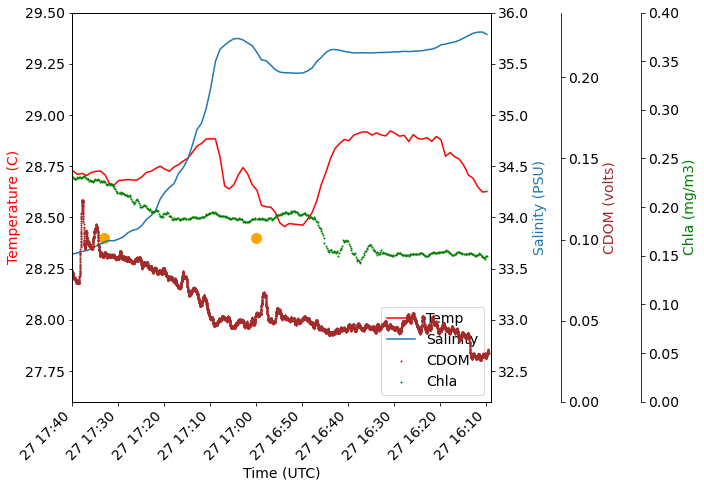

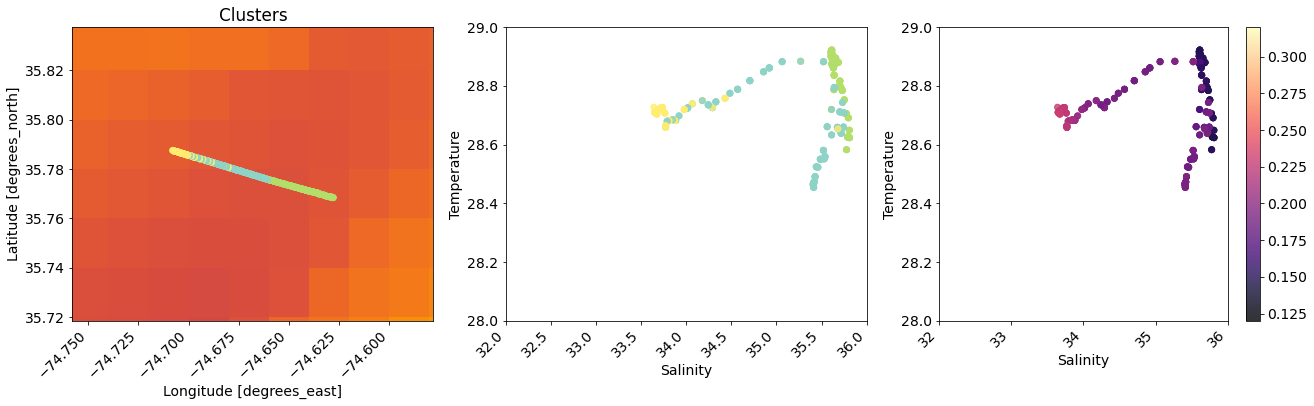

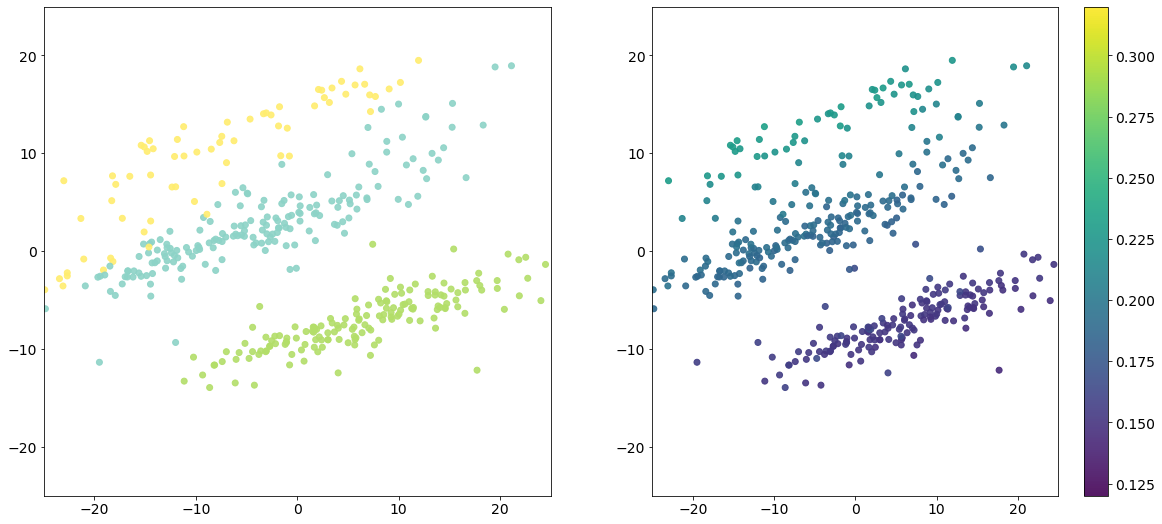

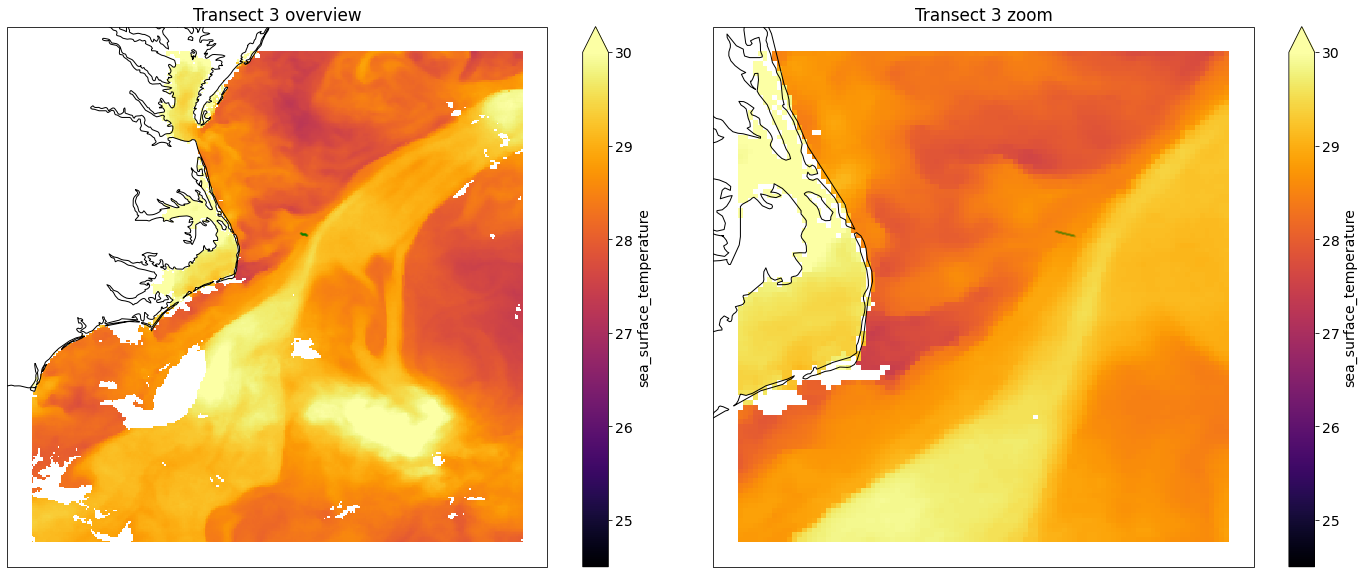

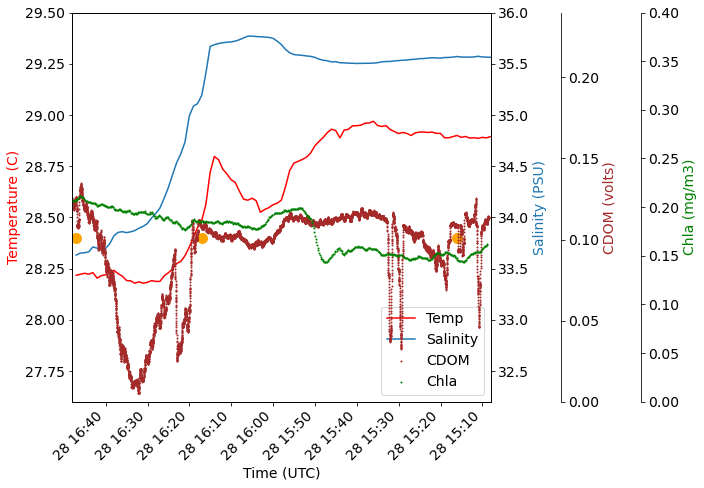

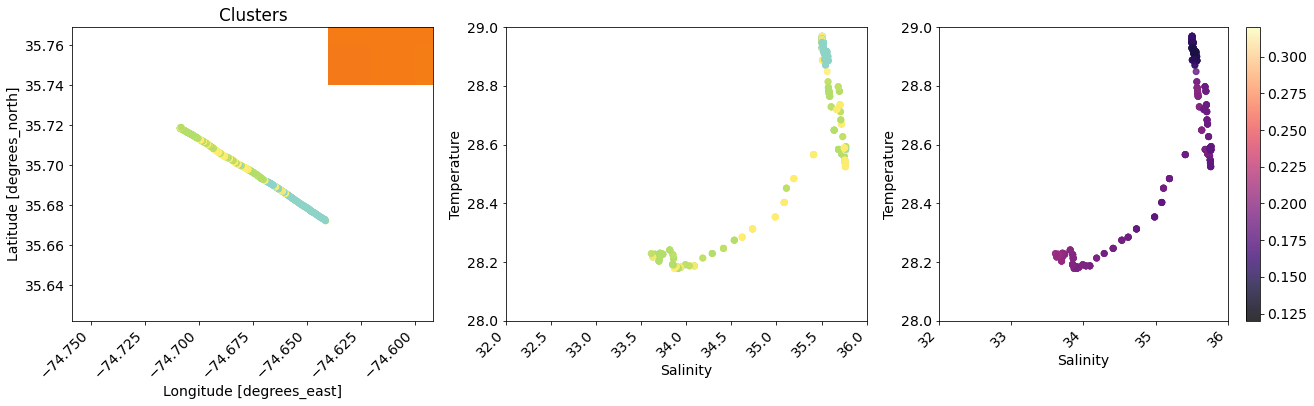

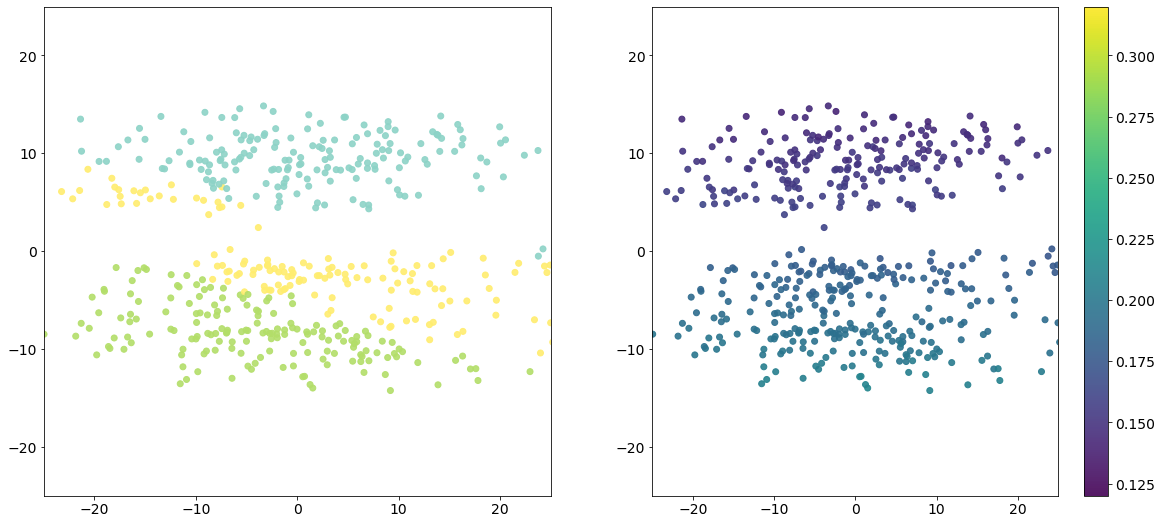

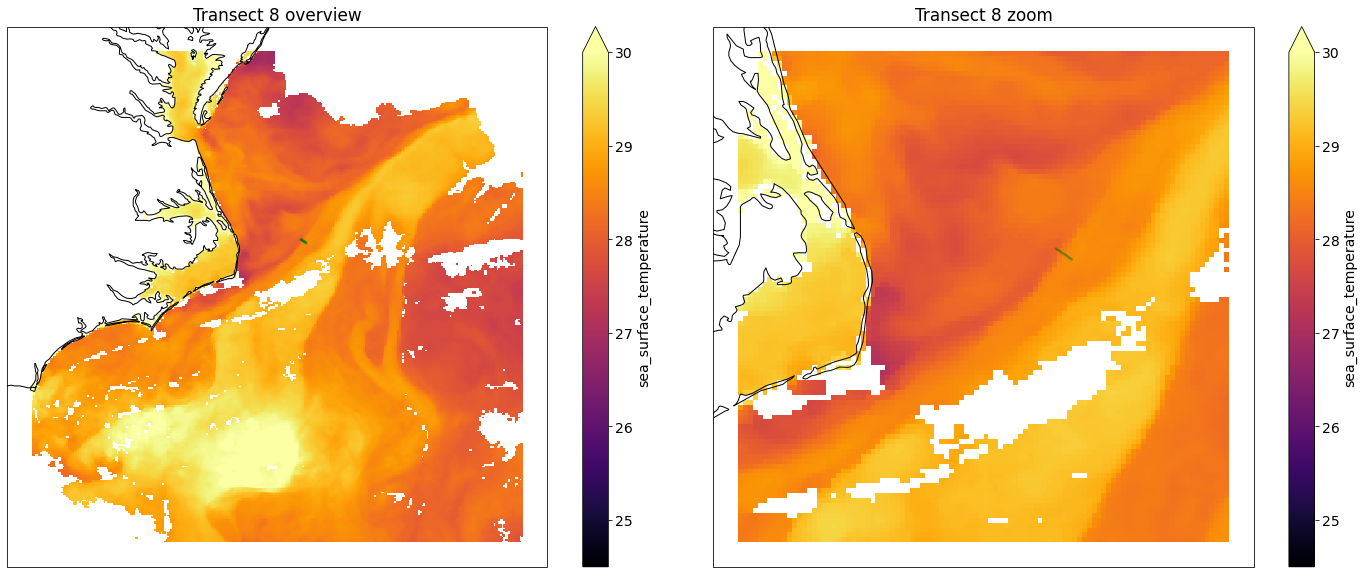

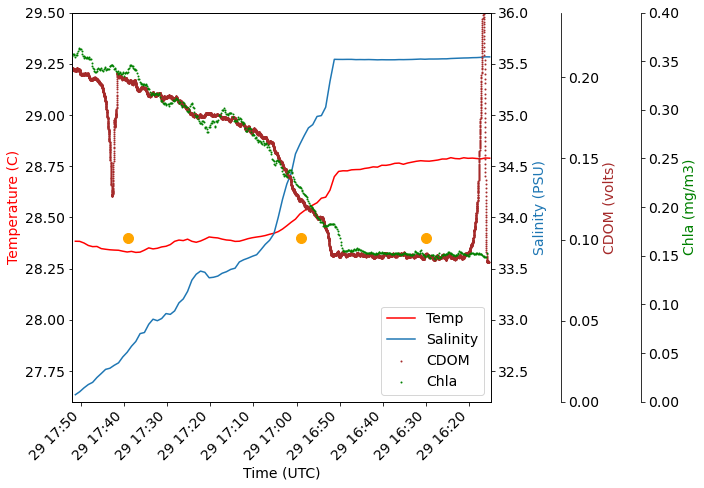

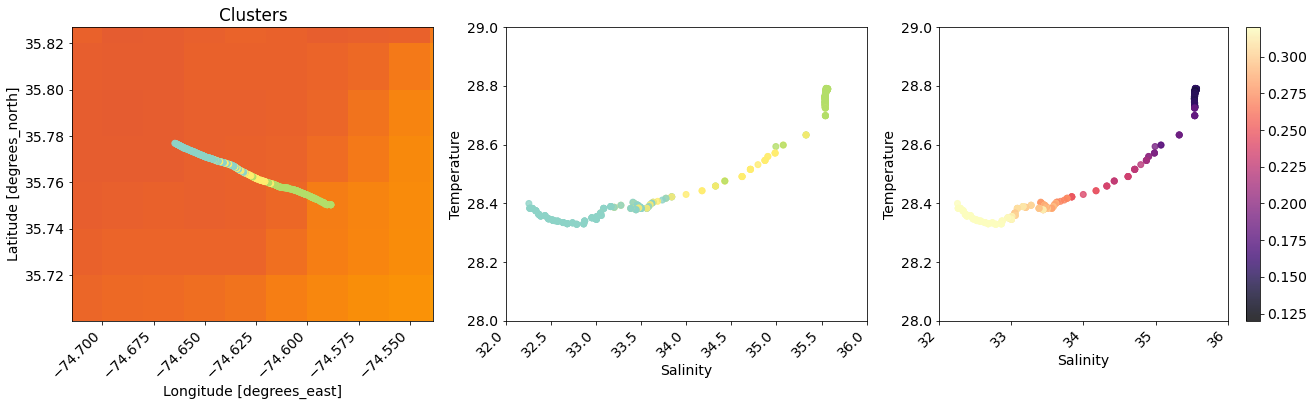

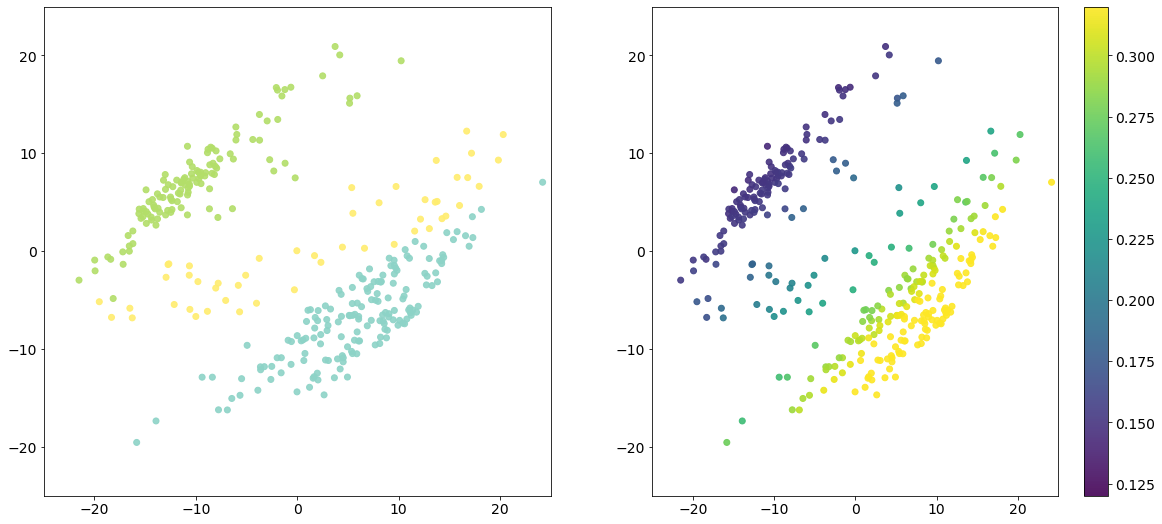

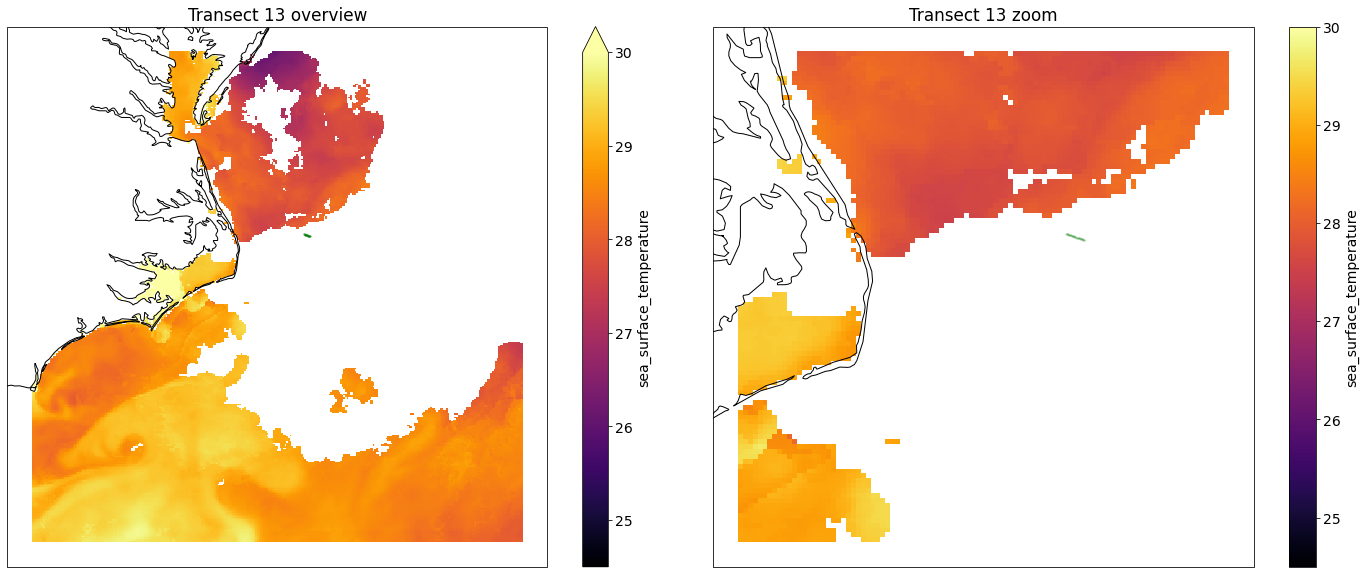

In [145]:
hours = [0,0,0,1,0,0,0,0,0,0,4,4,4]

titles = ['Transect 1', 'Transect 2', 'Transect 3', 'Transect 4', 
        'Transect 5', 'Transect 6', 'Transect 7', 'Transect 8',
        'Transect 9', 'Transect 10', 'Transect 11', 'Transect 12', 'Transect 13']

for i in range(13):
    if trios_df.loc[start_times[i]:end_times[i]]['chla_oci'].empty:
        pass
    elif hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
        pass
    else:
        # time series plot
        fig, ax = plt.subplots(figsize=(10,7))
        
        ax.set_xlim(pd.to_datetime(end_times[i]),pd.to_datetime(start_times[i]))

        ax1 = ax.twinx()
        ax2 = ax.twinx()
        ax3 = ax.twinx()

        ax.set_ylim(27.6, 29.5)
        ax1.set_ylim(32.2, 36)
        ax2.set_ylim(.0, .24)
        ax3.set_ylim(.0, .40)

        ax.set_xlabel("Time (UTC)")
        ax.set_ylabel("Temperature (C)")
        ax1.set_ylabel("Salinity (PSU)")
        ax2.set_ylabel("CDOM (volts)")
        ax3.set_ylabel("Chla (mg/m3)")

        color1 = plt.cm.viridis(0)
        color2 = plt.cm.viridis(0.5)
        color3 = plt.cm.viridis(.9)

        p1, = ax.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--temp-SBE38'], color='red', label='Temp')
        p2, = ax1.plot(df.loc[start_times[i]:end_times[i]].index, df.loc[start_times[i]:end_times[i]]['TSG--sal'], label='Salinity')
                
#         if hplc_df.loc[start_times[i]:end_times[i]]['datetime'].empty:
#             hplc_data_x = None
#             hplc_data_y = None
#         else:
#             hplc_data_x = hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)].index, 
#             hplc_data_y = [28.4]*len(hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)])
# #             print(hplc_df.loc[pd.to_datetime(start_times[i]) - timedelta(minutes=15):pd.to_datetime(end_times[i]) + timedelta(minutes=15)].Sample)
#         ax.scatter(hplc_data_x, hplc_data_y, color='orange', label='HPLC', s=100)
        
        if cdom_df.loc[start_times[i]:end_times[i]].rolling(window=6*10).mean()['cdom_volts'].empty:
            cdom_data_x = None
            cdom_data_y = None
        else:
            cdom_data_x = cdom_df.loc[start_times[i]:end_times[i]].index, 
            cdom_data_y = cdom_df.loc[start_times[i]:end_times[i]].rolling(window=60).mean()['cdom_volts']
        p3  = ax2.scatter(cdom_data_x, cdom_data_y, color='brown', label='CDOM', s=1)
        
        trios_data_x = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean().index
        trios_data_y = trios_df.loc[start_times[i]:end_times[i]].rolling(window=6*1).mean()['chla_oci']
        p4  = ax3.scatter(trios_data_x, trios_data_y, color='green', label='Chla', s=1)

#         ax.set_title(titles[i])


    #     p1, = ax.plot([0, 1, 2], [0, 1, 2],    color=color1, label="Density")
    #     p2, = ax1.plot([0, 1, 2], [0, 3, 2],    color=color2, label="Temperature")
    #     p3, = ax2.plot([0, 1, 2], [50, 30, 15], color=color3, label="Velocity")

        lns = [p1, p2, p3, p4]
        ax.legend(handles=lns, loc='lower right')

        # right, left, top, bottom
        ax2.spines['right'].set_position(('outward', 70))

        ax3.spines['right'].set_position(('outward', 150))

        # no x-ticks                 
    #     ax2.xaxis.set_ticks([])
        fig.autofmt_xdate(rotation=45)

        # Sometimes handy, same for xaxis
        #par2.yaxis.set_ticks_position('right')

        # Move "Velocity"-axis to the left
        # par2.spines['left'].set_position(('outward', 60))
        # par2.spines['left'].set_visible(True)
        # par2.yaxis.set_label_position('left')
        # par2.yaxis.set_ticks_position('left')

        ax.yaxis.label.set_color(p1.get_color())
        ax1.yaxis.label.set_color(p2.get_color())
        ax2.yaxis.label.set_color('brown')
        ax3.yaxis.label.set_color('green')

        # Adjust spacings w.r.t. figsize
        fig.tight_layout()
#         fig.savefig('figs/'+titles[i] +'.png')
    #     plt.close()
        plt.show()
        
        # cluster and T-S diagram
        
        trios_subset = trios_gdf.loc[start_times[i]:end_times[i]]
        # cutting off the parts most influenced by chla absorption
        kmeans = KMeans(n_clusters=3, random_state=0).fit(trios_subset.values[:,120:-315])
        
        fig, ax = plt.subplots(1,3, figsize=(22,6))
#         trios_subset.plot(ax=ax[0])
        
        trios_data_x = trios_subset.lon
        trios_data_y = trios_subset.lat
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=14), pd.to_datetime(end_times[i])-timedelta(hours=14))).sea_surface_temperature.mean(dim='time').plot(ax=ax[0], vmin=26.5, vmax=29.5, cmap='inferno', add_colorbar=False)

        ax[0].scatter(trios_data_x, trios_data_y, cmap='Set3', c=kmeans.labels_, label='cluster')
        
        
        ax[0].set_xlim(trios_data_x.min()-0.05, trios_data_x.max()+0.05)
        ax[0].set_ylim(trios_data_y.min()-0.05,trios_data_y.max()+0.05)

        # ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
        # fig.colorbar(sc,ax=ax)
        # fig.colorbar(sc, ax=ax)
        fig.autofmt_xdate(rotation=45)
        ax[0].set_title('Clusters')
        # fig.savefig('trios_radiometers_chlaci.png')
        
        ax[1].scatter(trios_subset['sal'], trios_subset['temp'], alpha=0.8, c=kmeans.labels_, cmap='Set3')
        ax[1].set_xlim(32,36)
        ax[1].set_ylim(28,29)

        ax[1].set_xlabel("Salinity")
        ax[1].set_ylabel("Temperature")
        
        sc = ax[2].scatter(trios_subset['sal'], trios_subset['temp'], alpha=0.8, c=trios_subset['chla_oci'], vmin=.12,vmax=.32, cmap='magma', label='chla')
        ax[2].set_xlim(32,36)
        ax[2].set_ylim(28,29)
        
        ax[2].set_xlabel("Salinity")
        ax[2].set_ylabel("Temperature")


        fig.colorbar(sc)
#         fig.savefig('aug_clusters_t_s_trios'+titles[i]+'.png')
        plt.show()
        
        x = trios_subset.values[:,120:-315]
#         x = x[12:,:]
        # Standardizing the features
        x = StandardScaler().fit_transform(x)
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(x)

        fig, ax = plt.subplots(1,2, figsize=(20,9))
        sc = ax[1].scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_subset['chla_oci'], vmin=.12,vmax=.32, cmap='viridis', label='chla')
        fig.colorbar(sc)
        ax[1].set_ylim(-25,25)
        ax[1].set_xlim(-25,25)
        ax[0].scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_, cmap='Set3')
        ax[0].set_ylim(-25,25)
        ax[0].set_xlim(-25,25)
        
        fig.savefig('aug_pca_t_s_trios'+titles[i]+'.png')
        
        plt.show()
        # ax.set_ylim(-3,2)
        # ax.set_xlim(-6,8)
        # fig.savefig('pca_transect.png')



        # SST image

        fig, ax = plt.subplots(1,2, figsize=(20,8), subplot_kw=dict(projection=crs.PlateCarree()))
        ax[0].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,:,:].mean(dim='time').plot(ax=ax[0], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[0], markersize=2, color='green', alpha=.05)

        ax[1].coastlines(resolution='10m')
        goes_ds.sel(time=slice(pd.to_datetime(start_times[i])-timedelta(hours=hours[i]), pd.to_datetime(end_times[i])+timedelta(hours=hours[i]))).sea_surface_temperature[:,75:175, 100:200].mean(dim='time').plot(ax=ax[1], vmin=24.5, vmax=30, cmap='inferno')
        gdf.loc[start_times[i]:end_times[i]].plot(ax=ax[1], markersize=2, color='green', alpha=.05)
        # fig.savefig('sst_sept0523_studypoints.png',dpi=400)
        ax[0].set_title(titles[i] + ' overview')
        ax[1].set_title(titles[i] + ' zoom')
        fig.tight_layout()
    #     fig.savefig('figs/'+titles[i] +'sat_overview.png')
    #     plt.close()
        plt.show()    

        # fig.savefig('transect' + str(i) '_s_t.png')

## Quantify uncertainty in the trios instrument on the SW

In this section I try to quantify uncertainty in the method by using a period where we didn't move much and then propogate that error to the chla measurement.

In [47]:
static_trios_df = trios_df.loc['2021-08-26 19:46:00':'2021-08-26 19:55:00']
len(static_trios_df)

55

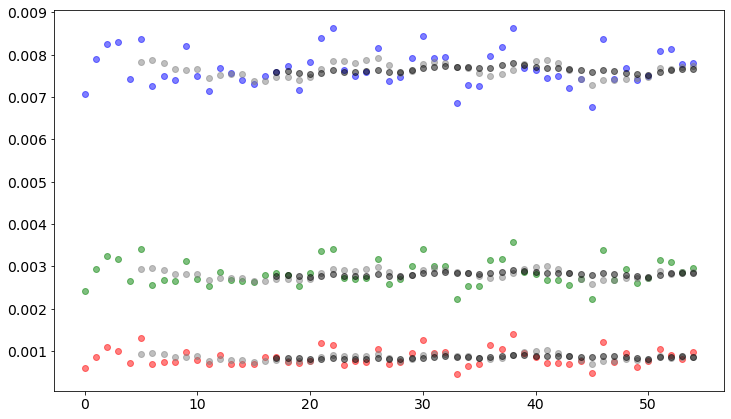

In [48]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:#,[232,240,'green'],[346,351,'red']]:
#     band_mean = static_trios_df.iloc[:, l:u].mean().mean()
#     band_std = static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1).std()
    
#     ax.axhline(band_mean,color=c)
#     ax.axhline(band_mean+band_std,color=c, ls='--')
#     ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='grey', alpha=0.5)
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=0.5)
    
# ax.set_ylim(-0.001,0.004)
plt.show()

Text(0.5, 0, 'Repeated measurement count')

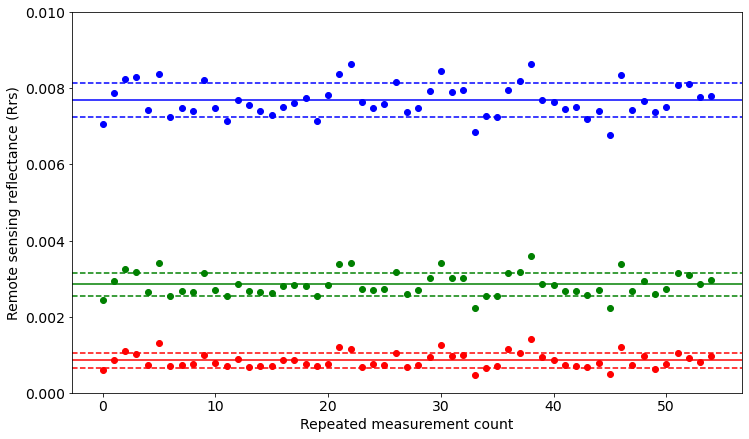

In [51]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue'],[232,240,'green'],[346,351,'red']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    band_std = static_trios_df.iloc[:, l:u].mean(axis=1).std()
    
    
    ax.axhline(band_mean,color=c)
    ax.axhline(band_mean+band_std,color=c, ls='--')
    ax.axhline(band_mean-band_std,color=c, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1)
#     ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1)

ax.set_ylim(0,0.01)

ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_trios.png',dpi=300)

Text(0.5, 0, 'Repeated measurement count')

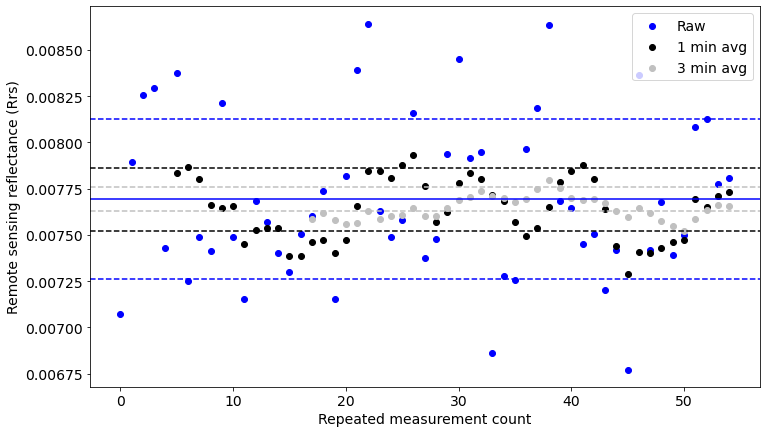

In [53]:
fig, ax = plt.subplots(figsize=(12,7))

for l,u,c in [[156,161,'blue']]:
    band_mean = static_trios_df.iloc[:, l:u].mean().mean()
    ax.axhline(band_mean,color=c)
    
    for i,c_std in [[1,'blue'],[6,'black'],[6*3,'silver']]:
        band_std = static_trios_df.rolling(window=i).mean().iloc[:, l:u].mean(axis=1).std()
        ax.axhline(band_mean+band_std,color=c_std, ls='--')
        ax.axhline(band_mean-band_std,color=c_std, ls='--')


    ax.scatter(range(len(static_trios_df)),static_trios_df.iloc[:, l:u].mean(axis=1),color=c, alpha=1, label='Raw')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6).mean().iloc[:, l:u].mean(axis=1),color='black', alpha=1, label='1 min avg')
    ax.scatter(range(len(static_trios_df)),static_trios_df.rolling(window=6*3).mean().iloc[:, l:u].mean(axis=1),color='silver', alpha=1, label='3 min avg')
ax.legend(loc='upper right')    
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Repeated measurement count')
# fig.savefig('repeated_measurements_blue_avg.png',dpi=300)

You need the uncertainties package for this.

In [54]:
# pip install --upgrade uncertainties

In [55]:
from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.

In [56]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

In [57]:
blue_u = ufloat(static_trios_df.iloc[:, 156:161].mean().mean(), np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values))
green_u = ufloat(static_trios_df.iloc[:, 232:240].mean().mean(), np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values))
red_u = ufloat(static_trios_df.iloc[:, 346:351].mean().mean(), np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values))
blue_u, green_u, red_u

(0.007692916094545454+/-0.0004316484016933594,
 0.002850563672727273+/-0.0003025047880319788,
 0.000854057709090909+/-0.00020191965759646383)

Uncertainty based on the group of wavelengths used to calculate chla.

In [59]:
blue_uncert = np.std(static_trios_df.iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.std(static_trios_df.iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.std(static_trios_df.iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.0004316484016933594, 0.0003025047880319788, 0.00020191965759646383)

Uncertainty based on a rolling window average of 6 measurements (1 minute)

In [306]:
blue_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 156:161].mean(axis=1).values)
green_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 232:240].mean(axis=1).values)
red_uncert = np.nanstd(static_trios_df.rolling(window=6).mean().iloc[:, 346:351].mean(axis=1).values)
blue_uncert, green_uncert, red_uncert

(0.00016776638783025022, 0.00010788283891465276, 7.161309946806462e-05)

In [62]:
chla_uncerts = []

for i in range(len(trios_df)):
    blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
    green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
    red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)
    
    chla_u = oc_index(blue_u, green_u, red_u)
    
    chla_uncert = chla_u.s
    chla_uncerts.append(chla_uncert)

Example of calculating uncertainty

In [63]:
blue_u = ufloat(trios_df.iloc[i, 156:161].mean(), blue_uncert)
green_u = ufloat(trios_df.iloc[i, 232:240].mean(), green_uncert) 
red_u = ufloat(trios_df.iloc[i, 346:351].mean(), red_uncert)

chla_u = oc_index(blue_u, green_u, red_u)

In [64]:
trios_df.iloc[i, 156:161].mean(), blue_uncert

(0.0075986914000000004, 0.0004316484016933594)

In [65]:
-260.43*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000167

-0.006779260494532654

In [66]:
(441.41*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.000107)

0.007362084289281303

In [67]:
(-180.98*(10**(-.49+191.7*(0.0024-0.59*0.0064-.41*0.00068)))*0.0000716)

-0.002019846872409247

In [68]:
import math
math.sqrt(0.0068**2+0.0074**2+0.002**2)

0.010246950765959599

In [69]:
blue_u, green_u, red_u

(0.0075986914000000004+/-0.0004316484016933594,
 0.004682888499999999+/-0.0003025047880319788,
 0.0030533482+/-0.00020191965759646383)

In [70]:
chla_u.error_components()

{0.0075986914000000004+/-0.0004316484016933594: 0.022862937692841537,
 0.0030533482+/-0.00020191965759646383: 0.007448298560927712,
 0.004682888499999999+/-0.0003025047880319788: 0.027181268898308585}

In [71]:
chla_u

0.20360693550654468+/-0.03629066615979417

In [72]:
chla_u

0.20360693550654468+/-0.03629066615979417

In [73]:
trios_df['chla_uncert'] = chla_uncerts

<ipython-input-74-779b19d7db1a>:5: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-74-779b19d7db1a>:6: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-74-779b19d7db1a>:7: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


Text(0.5, 0, 'Wavelength (nm)')

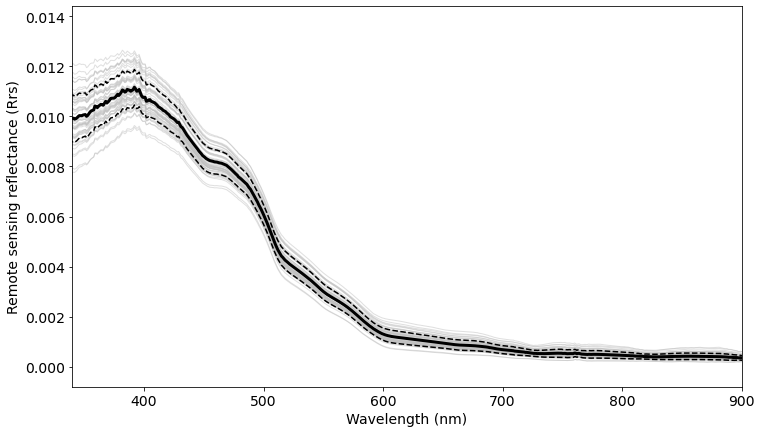

In [74]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2].values.T, color='silver', lw=1, alpha=0.5)
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
# ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')
# fig.savefig('spectrum_repeated.png',dpi=300)

(340.0, 900.0)

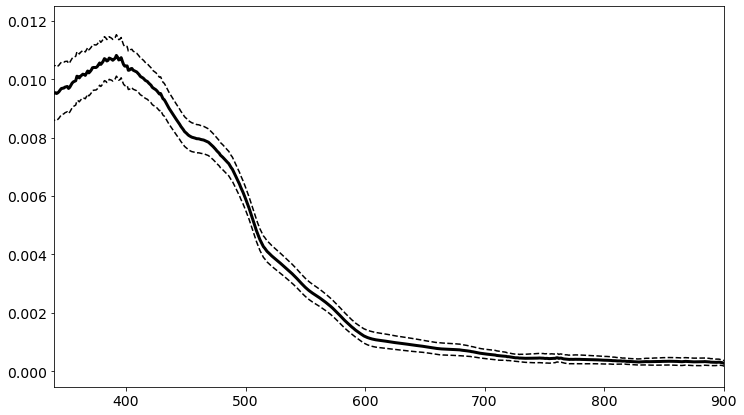

In [75]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2], color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[50, 1:-2]-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


<ipython-input-76-f8aafffdfa3d>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
<ipython-input-76-f8aafffdfa3d>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
<ipython-input-76-f8aafffdfa3d>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')


(340.0, 900.0)

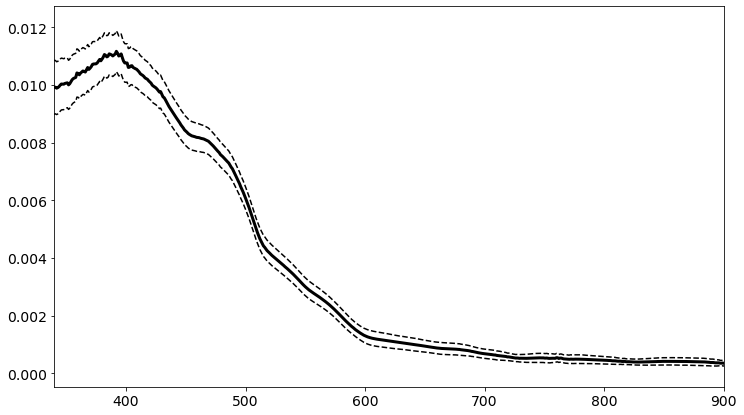

In [76]:
fig, ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean(), color='black', lw=3)
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()+static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), static_trios_df.iloc[:, :-1].mean()-static_trios_df.iloc[:, :-2].std(), color='black', ls='--')
ax.set_xlim(340,900)


### Now look at this on a specific transect

In [29]:
transect = 2
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = trios_df.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]

Text(0.5, 1.0, '')

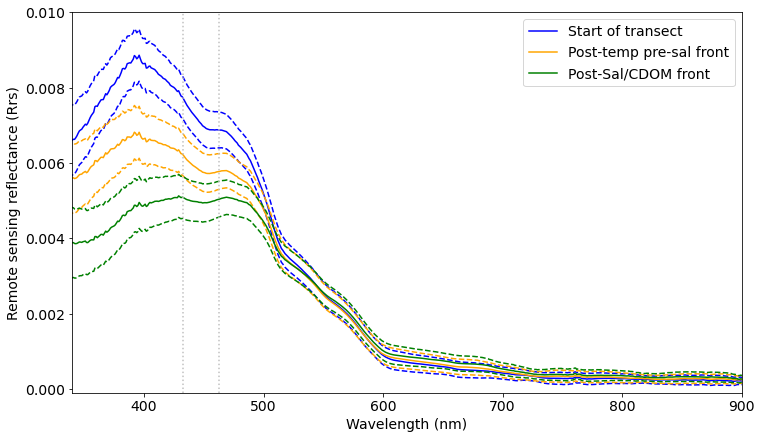

In [79]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')


# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)

ax.set_title('')


# plt.savefig('radiometry_spectra_across_front.png',dpi=300)


(-0.0001, 0.01)

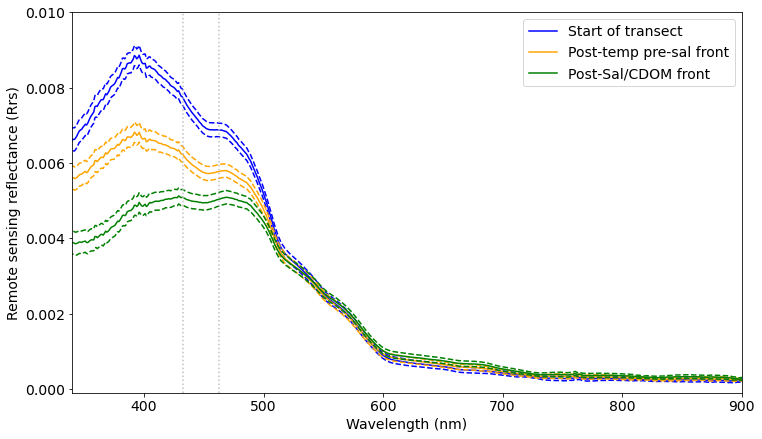

In [80]:
fig,ax = plt.subplots(figsize=(12,7))
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2],label='Start of transect', color='blue',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='blue', ls='--')


# trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
# trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')

# trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp pre-sal front')
ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2],label='Post-temp pre-sal front', color='orange',)
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='orange', ls='--')



ax.plot(static_trios_df.columns[1:-2].astype(int),trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2],label='Post-Sal/CDOM front',  color='green', )
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]+static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')
ax.plot(static_trios_df.columns[1:-2].astype(int), trios_df_transect.loc['2021-08-27 17:34:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2]-static_trios_df.rolling(6).mean().iloc[:, :-2].std(), color='green', ls='--')


ax.axvline(443-10, color='silver', ls='dotted')
ax.axvline(443+20, color='silver', ls='dotted')

ax.legend()
ax.set_ylabel('Remote sensing reflectance (Rrs)')
ax.set_xlabel('Wavelength (nm)')

ax.set_xlim(340,900)
ax.set_ylim(-0.0001,0.01)



# plt.savefig('radiometry_spectra_across_front_binned.png',dpi=300)


In [81]:
start_times[transect]

'2021-08-27 16:09:00'

In [82]:
end_times[transect]

'2021-08-27 17:40:00'

In [83]:
plt.rcParams.update({'font.size': 16})

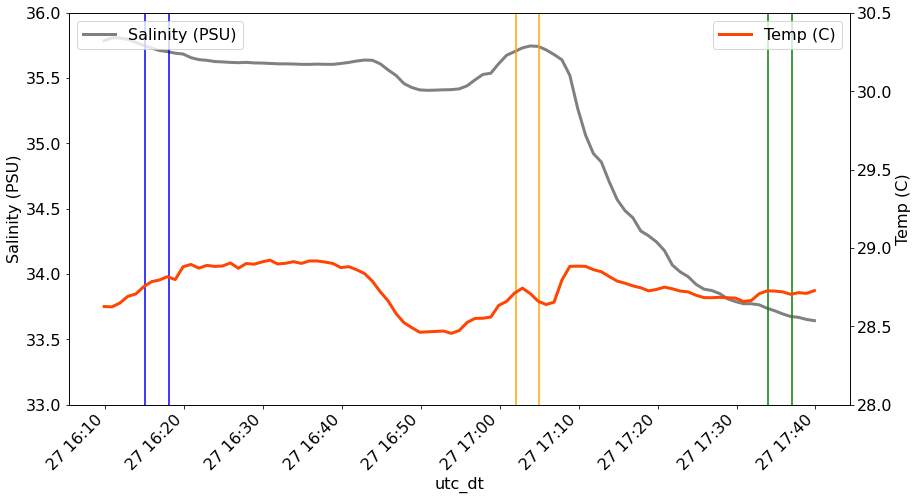

In [84]:
fig, ax = plt.subplots(figsize=(14,8))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax.axvline('2021-08-27 16:15:00',color='blue')
ax.axvline('2021-08-27 16:18:00',color='blue')

ax.axvline('2021-08-27 17:02:00',color='orange')
ax.axvline('2021-08-27 17:05:00',color='orange')

ax.axvline('2021-08-27 17:34:00',color='green')
ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('sal_temp_front.png')

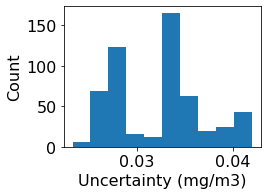

In [86]:
fig, ax = plt.subplots(figsize=(4,3))
ax.hist(trios_df_transect['chla_uncert'])
ax.set_ylabel('Count')
ax.set_xlabel('Uncertainty (mg/m3)')
fig.tight_layout()
# fig.savefig('uncertanty_distribution.png',dpi=300)

In [87]:
trios_df_transect['chla_oci']

utc_dt
2021-08-27 16:09:00    0.151699
2021-08-27 16:09:10    0.153381
2021-08-27 16:09:20    0.151364
2021-08-27 16:09:30    0.147087
2021-08-27 16:09:40    0.149037
                         ...   
2021-08-27 17:39:20    0.232420
2021-08-27 17:39:30    0.227189
2021-08-27 17:39:40    0.233379
2021-08-27 17:39:50    0.235517
2021-08-27 17:40:00    0.221562
Name: chla_oci, Length: 541, dtype: float64

The uncertainty is basically proportional to the chla

In [88]:
np.unique(trios_df_transect['chla_uncert']/trios_df_transect['chla_oci'])

array([0.17823885, 0.17823885, 0.17823885, 0.17823885])

In [325]:
trios_df_transect['chla_oci']

utc_dt
2021-08-27 16:09:00    0.151699
2021-08-27 16:09:10    0.153381
2021-08-27 16:09:20    0.151364
2021-08-27 16:09:30    0.147087
2021-08-27 16:09:40    0.149037
                         ...   
2021-08-27 17:39:20    0.232420
2021-08-27 17:39:30    0.227189
2021-08-27 17:39:40    0.233379
2021-08-27 17:39:50    0.235517
2021-08-27 17:40:00    0.221562
Name: chla_oci, Length: 541, dtype: float64

In [89]:
trios_df_transect['chla_uncert']

utc_dt
2021-08-27 16:09:00    0.027039
2021-08-27 16:09:10    0.027338
2021-08-27 16:09:20    0.026979
2021-08-27 16:09:30    0.026217
2021-08-27 16:09:40    0.026564
                         ...   
2021-08-27 17:39:20    0.041426
2021-08-27 17:39:30    0.040494
2021-08-27 17:39:40    0.041597
2021-08-27 17:39:50    0.041978
2021-08-27 17:40:00    0.039491
Name: chla_uncert, Length: 541, dtype: float64

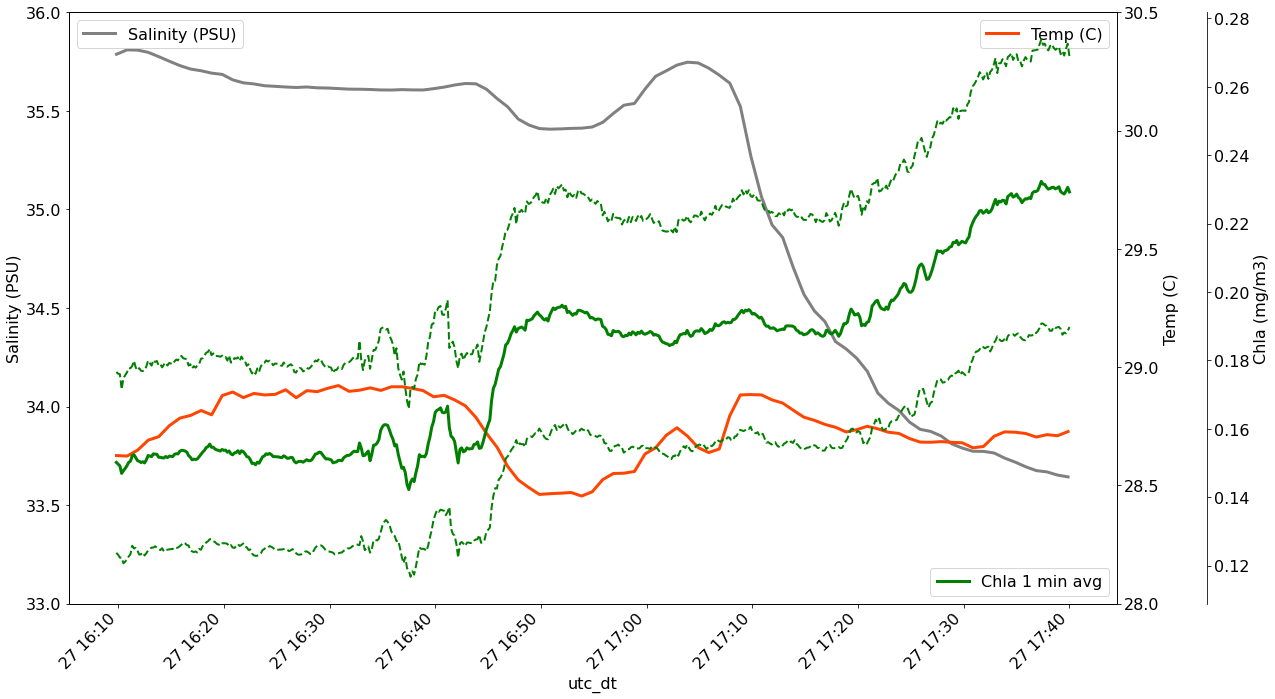

In [90]:
fig, ax = plt.subplots(figsize=(18,10))

df_transect.plot(y='TSG--sal',ax=ax, linewidth=3, color='grey', label='Salinity (PSU)')
ax.set_ylim(33,36)

ax1 = ax.twinx()
df_transect.plot(y='TSG--temp-SBE38',ax=ax1, linewidth=3, color='orangered', label='Temp (C)')
ax1.set_ylim(28,30.5)

ax2 = ax.twinx()

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax2, color='green', label='Chla 1 min avg', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax2, color='green', label='', linewidth=2, ls='--')

# ax.axvline('2021-08-27 16:15:00',color='blue')
# ax.axvline('2021-08-27 16:18:00',color='blue')

# ax.axvline('2021-08-27 17:02:00',color='orange')
# ax.axvline('2021-08-27 17:05:00',color='orange')

# ax.axvline('2021-08-27 17:34:00',color='green')
# ax.axvline('2021-08-27 17:37:00',color='green')

ax.legend(loc='upper left')
ax1.legend(loc='upper right')
ax2.legend(loc='lower right')

ax.set_ylabel('Salinity (PSU)')
ax1.set_ylabel('Temp (C)')
ax2.set_ylabel('Chla (mg/m3)')

ax2.spines['right'].set_position(('outward', 90))

# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
fig.tight_layout()
# fig.savefig('chla_uncert_sal_temp.png')

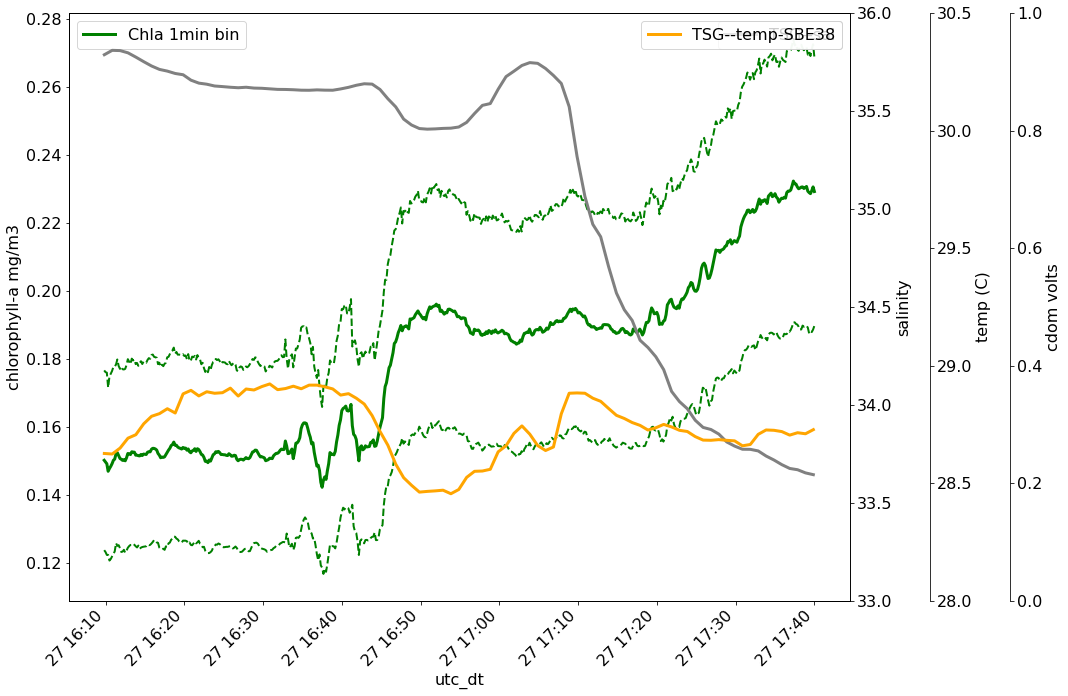

In [91]:
fig, ax = plt.subplots(figsize=(14,12))

ax2 = ax.twinx()
ax3 = ax.twinx()
ax4 = ax.twinx()

ax3.spines['right'].set_position(('outward', 80))
ax4.spines['right'].set_position(('outward', 160))


df_transect.plot(y='TSG--sal',ax=ax2, linewidth=3, color='grey')
ax2.set_ylim(33,36)

df_transect.plot(y='TSG--temp-SBE38',ax=ax3, linewidth=3, color='orange')
ax3.set_ylim(28,30.5)

trios_df_transect['chla_oci'].rolling(window=6).mean().plot(ax=ax, color='green', label='Chla 1min bin', linewidth=3)
(trios_df_transect['chla_oci'].rolling(window=6).mean()-trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')
(trios_df_transect['chla_oci'].rolling(window=6).mean()+trios_df_transect['chla_uncert']).plot(ax=ax, color='green', label='', linewidth=2, ls='--')

ax.legend(loc='upper left')
ax.set_ylabel('chlorophyll-a mg/m3')
ax2.set_ylabel('salinity')
ax3.set_ylabel('temp (C)')
ax4.set_ylabel('cdom volts')


# ax.set_ylim(0.000,0.012)
fig.autofmt_xdate(rotation=45)
# fig.savefig('chla_uncert_sal_temp.png')

### Explore the radiometer data a bit more

Checking out and clustering a transect

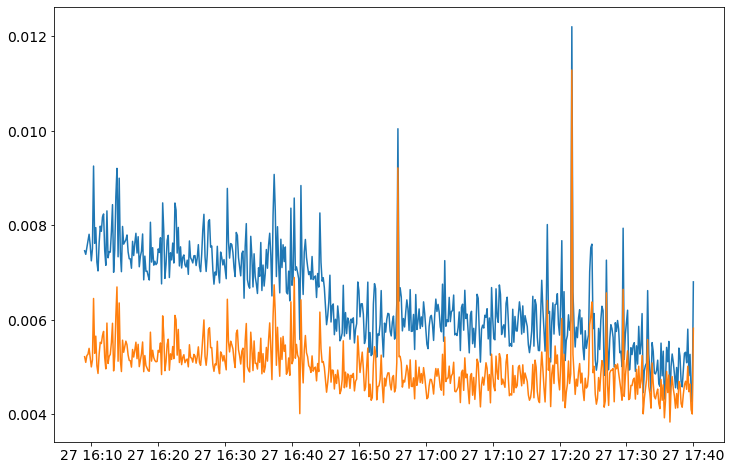

In [79]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(trios_df_transect['440'].rolling(window=1).mean())
ax.plot(trios_df_transect['500'].rolling(window=1).mean())


In [317]:
len(start_times)

13

In [34]:
transect = 12
df_transect = df.loc[start_times[transect]:end_times[transect]]
trios_df_transect = trios_df.loc[start_times[transect]:end_times[transect]]
cdom_df_transect = cdom_df.loc[start_times[transect]:end_times[transect]]


In [35]:
# Calculate rolling median
rolling_440 = trios_df_transect['440'].rolling(window=6*2).median()
upper_threshold = 0.0005
lower_threshold = -0.0005

# all in one line 
df_filtered = trios_df_transect.drop(trios_df_transect[(trios_df_transect['440']-rolling_440>upper_threshold)|(trios_df_transect['440']- rolling_440<lower_threshold)].index) 
# if you want to drop the column as well
# del df["rolling_temp"]

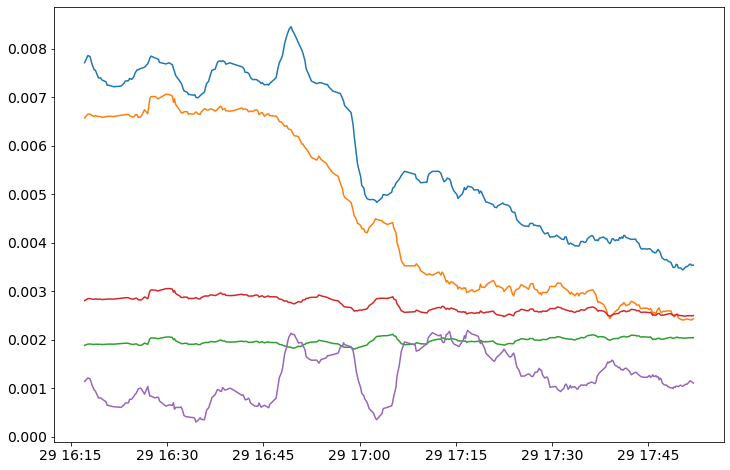

In [36]:
fig, ax = plt.subplots(figsize=(12,8))
# ax.plot(trios_df_transect['440'].rolling(window=1).mean())
# ax.plot(trios_df_transect['460'].rolling(window=1).mean())
# ax.plot(trios_df_transect['440'].rolling(window=6*3).mean())
# ax.plot(df_filtered['440'])
ax.plot(df_filtered['440'].rolling(window=6*2).mean())
ax.plot(df_filtered['440'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())
ax.plot(df_filtered['550'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())

ax.plot(df_filtered['520'].rolling(window=6*2).mean()-df_filtered['660'].rolling(window=6*2).mean())


ax.plot(df_filtered['660'].rolling(window=6*2).mean())

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [37]:
df_filtered.iloc[:,1:-2]

320       321       322       323       324  \
utc_dt                                                                  
2021-08-29 16:15:10  0.005114  0.005222  0.005263  0.005213  0.005151   
2021-08-29 16:15:20  0.005856  0.005944  0.005960  0.005886  0.005808   
2021-08-29 16:15:30  0.007062  0.007106  0.007089  0.007012  0.006933   
2021-08-29 16:15:40  0.006130  0.006210  0.006234  0.006173  0.006105   
2021-08-29 16:15:50  0.006626  0.006690  0.006703  0.006633  0.006552   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.003403  0.003446  0.003451  0.003403  0.003342   
2021-08-29 17:51:00  0.003165  0.003203  0.003202  0.003158  0.003104   
2021-08-29 17:51:30  0.003332  0.003375  0.003376  0.003336  0.003281   
2021-08-29 17:51:40  0.002666  0.002694  0.002687  0.002651  0.002599   
2021-08-29 17:52:00  0.004100  0.004148  0.004151  0.004094  0.004020   

                          325       326       327       328       329  ...  \
utc_dt                                                                 ...   
2021-08-29 16:15:10  0.005104  0.005136  0.005065  0.004927  0.004996  ...   
2021-08-29 16:15:20  0.005748  0.005771  0.005692  0.005550  0.005628  ...   
2021-08-29 16:15:30  0.006873  0.006898  0.006812  0.006656  0.006719  ...   
2021-08-29 16:15:40  0.006053  0.006076  0.005999  0.005859  0.005925  ...   
2021-08-29 16:15:50  0.006487  0.006513  0.006442  0.006306  0.006369  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.003295  0.003297  0.003224  0.003109  0.003144  ...   
2021-08-29 17:51:00  0.003064  0.003071  0.003000  0.002887  0.002922  ...   
2021-08-29 17:51:30  0.003240  0.003246  0.003172  0.003055  0.003089  ...   
2021-08-29 17:51:40  0.002559  0.002560  0.002492  0.002386  0.002422  ...   
2021-08-29 17:52:00  0.003961  0.003962  0.003878  0.003743  0.003773  ...   

                          941       942       943       944       945  \
utc_dt                                                                  
2021-08-29 16:15:10 -0.000540 -0.000588 -0.000501 -0.000380 -0.000261   
2021-08-29 16:15:20  0.000032 -0.000098  0.000016  0.000121  0.000225   
2021-08-29 16:15:30  0.000774  0.000721  0.000598  0.000537  0.000477   
2021-08-29 16:15:40  0.000475  0.000510  0.000535  0.000505  0.000473   
2021-08-29 16:15:50 -0.000072 -0.000043  0.000073  0.000190  0.000306   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.000499  0.000532  0.000503  0.000487  0.000472   
2021-08-29 17:51:00  0.000216  0.000156  0.000135  0.000163  0.000192   
2021-08-29 17:51:30  0.001219  0.001187  0.001195  0.001245  0.001295   
2021-08-29 17:51:40  0.000615  0.000608  0.000652  0.000668  0.000681   
2021-08-29 17:52:00 -0.000191 -0.000196 -0.000262 -0.000326 -0.000389   

                          946       947       948       949       950  
utc_dt                                                                 
2021-08-29 16:15:10 -0.000355 -0.000570 -0.000821 -0.000906 -0.000869  
2021-08-29 16:15:20  0.000099 -0.000029 -0.000143 -0.000068  0.000041  
2021-08-29 16:15:30  0.000580  0.000604  0.000588  0.000598  0.000657  
2021-08-29 16:15:40  0.000465  0.000465  0.000468  0.000540  0.000640  
2021-08-29 16:15:50  0.000350  0.000381  0.000411  0.000389  0.000327  
...                       ...       ...       ...       ...       ...  
2021-08-29 17:50:50  0.000479  0.000473  0.000461  0.000465  0.000468  
2021-08-29 17:51:00  0.000211  0.000224  0.000234  0.000240  0.000236  
2021-08-29 17:51:30  0.001343  0.001358  0.001360  0.001333  0.001300  
2021-08-29 17:51:40  0.000725  0.000757  0.000782  0.000729  0.000647  
2021-08-29 17:52:00 -0.000361 -0.000335 -0.000314 -0.000278 -0.000241  

[344 rows x 631 columns]

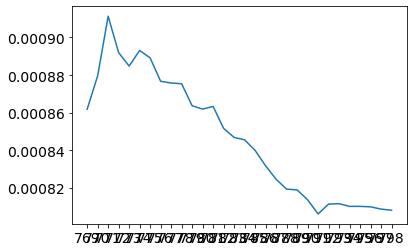

In [38]:
plt.plot(df_filtered.iloc[:,450:480].mean())

In [39]:
corrected_specs = []
for i in range(len(df_filtered.iloc[:,1:-2])):
    corrected_specs.append(df_filtered.iloc[i,1:-2] - df_filtered.iloc[i,450:480].mean())

In [40]:
corrected_specs = pd.DataFrame(corrected_specs, columns=df_filtered.columns[1:-2] )

In [41]:
corrected_specs['chla_oci'] = oc_index(corrected_specs.iloc[:, 156:161].mean(axis=1).values, corrected_specs.iloc[:, 232:240].mean(axis=1).values, corrected_specs.iloc[:, 346:351].mean(axis=1).values)

In [42]:
corrected_specs['TimeStamp'] = df_filtered['TimeStamp']

<AxesSubplot:xlabel='utc_dt'>

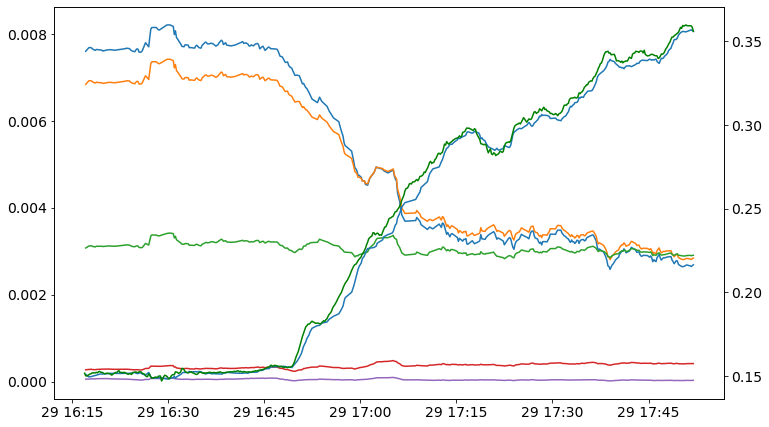

In [43]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(corrected_specs['420'].rolling(window=6*2).mean())
ax.plot(corrected_specs['440'].rolling(window=6*2).mean())

ax.plot(corrected_specs['520'].rolling(window=6*2).mean())


ax.plot(corrected_specs['660'].rolling(window=6*2).mean())
ax.plot(corrected_specs['750'].rolling(window=6*2).mean())

ax2 = ax.twinx()
ax2.plot(corrected_specs['chla_oci'].rolling(window=6*2).mean())
trios_df_transect['chla_oci'].rolling(window=6*2).mean().plot(ax=ax2, color='green')

# ax.set_ylim(0.002,0.01)
# trios_df_transect.plot('440')

In [100]:
trios_df_transect

TimeStamp       320       321       322  \
utc_dt                                                                  
2021-08-29 16:15:10  8/29/2021 12:15:10  0.005114  0.005222  0.005263   
2021-08-29 16:15:20  8/29/2021 12:15:20  0.005856  0.005944  0.005960   
2021-08-29 16:15:30  8/29/2021 12:15:30  0.007062  0.007106  0.007089   
2021-08-29 16:15:40  8/29/2021 12:15:40  0.006130  0.006210  0.006234   
2021-08-29 16:15:50  8/29/2021 12:15:50  0.006626  0.006690  0.006703   
...                                 ...       ...       ...       ...   
2021-08-29 17:51:20  8/29/2021 13:51:20  0.004854  0.004898  0.004895   
2021-08-29 17:51:30  8/29/2021 13:51:30  0.003332  0.003375  0.003376   
2021-08-29 17:51:40  8/29/2021 13:51:40  0.002666  0.002694  0.002687   
2021-08-29 17:51:50  8/29/2021 13:51:50  0.004869  0.004917  0.004919   
2021-08-29 17:52:00  8/29/2021 13:52:00  0.004100  0.004148  0.004151   

                          323       324       325       326       327  \
utc_dt                                                                  
2021-08-29 16:15:10  0.005213  0.005151  0.005104  0.005136  0.005065   
2021-08-29 16:15:20  0.005886  0.005808  0.005748  0.005771  0.005692   
2021-08-29 16:15:30  0.007012  0.006933  0.006873  0.006898  0.006812   
2021-08-29 16:15:40  0.006173  0.006105  0.006053  0.006076  0.005999   
2021-08-29 16:15:50  0.006633  0.006552  0.006487  0.006513  0.006442   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:51:20  0.004826  0.004736  0.004664  0.004668  0.004576   
2021-08-29 17:51:30  0.003336  0.003281  0.003240  0.003246  0.003172   
2021-08-29 17:51:40  0.002651  0.002599  0.002559  0.002560  0.002492   
2021-08-29 17:51:50  0.004839  0.004745  0.004670  0.004682  0.004604   
2021-08-29 17:52:00  0.004094  0.004020  0.003961  0.003962  0.003878   

                          328  ...       943       944       945       946  \
utc_dt                         ...                                           
2021-08-29 16:15:10  0.004927  ... -0.000501 -0.000380 -0.000261 -0.000355   
2021-08-29 16:15:20  0.005550  ...  0.000016  0.000121  0.000225  0.000099   
2021-08-29 16:15:30  0.006656  ...  0.000598  0.000537  0.000477  0.000580   
2021-08-29 16:15:40  0.005859  ...  0.000535  0.000505  0.000473  0.000465   
2021-08-29 16:15:50  0.006306  ...  0.000073  0.000190  0.000306  0.000350   
...                       ...  ...       ...       ...       ...       ...   
2021-08-29 17:51:20  0.004427  ...  0.001078  0.001156  0.001232  0.001153   
2021-08-29 17:51:30  0.003055  ...  0.001195  0.001245  0.001295  0.001343   
2021-08-29 17:51:40  0.002386  ...  0.000652  0.000668  0.000681  0.000725   
2021-08-29 17:51:50  0.004466  ...  0.002200  0.002370  0.002538  0.002440   
2021-08-29 17:52:00  0.003743  ... -0.000262 -0.000326 -0.000389 -0.000361   

                          947       948       949       950  \
utc_dt                                                        
2021-08-29 16:15:10 -0.000570 -0.000821 -0.000906 -0.000869   
2021-08-29 16:15:20 -0.000029 -0.000143 -0.000068  0.000041   
2021-08-29 16:15:30  0.000604  0.000588  0.000598  0.000657   
2021-08-29 16:15:40  0.000465  0.000468  0.000540  0.000640   
2021-08-29 16:15:50  0.000381  0.000411  0.000389  0.000327   
...                       ...       ...       ...       ...   
2021-08-29 17:51:20  0.001040  0.000924  0.000928  0.001006   
2021-08-29 17:51:30  0.001358  0.001360  0.001333  0.001300   
2021-08-29 17:51:40  0.000757  0.000782  0.000729  0.000647   
2021-08-29 17:51:50  0.002279  0.002108  0.002110  0.002233   
2021-08-29 17:52:00 -0.000335 -0.000314 -0.000278 -0.000241   

                               datetime  chla_oci  
utc_dt                                             
2021-08-29 16:15:10 2021-08-29 12:15:10  0.169043  
2021-08-29 16:15:20 2021-08-29 12:15:20  0.150944  
2021-08-29 16:15:30 2021-08-29 12:15:30  0.150044  
2021-08-29 16:15:40 2021-08-29 12:1

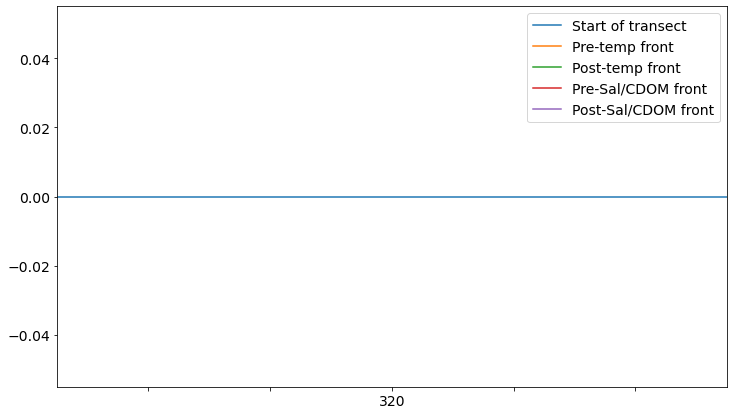

In [96]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
fig,ax = plt.subplots(figsize=(12,7))
trios_df_transect.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

trios_df_transect.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
trios_df_transect.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
trios_df_transect.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
trios_df_transect.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.legend()
# plt.savefig('radiometry_spectra.png')


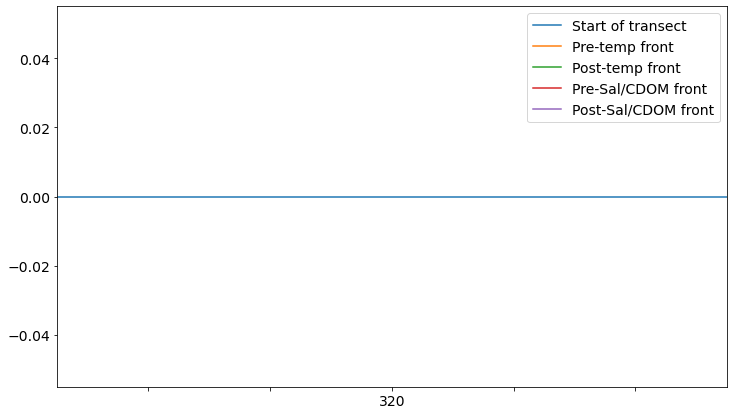

In [45]:
fig,ax = plt.subplots(figsize=(12,7))
corrected_specs.loc['2021-08-27 16:15:00':'2021-08-27 16:20:00'].median(numeric_only=True).iloc[:-2].plot(label='Start of transect')

corrected_specs.loc['2021-08-27 16:37:00':'2021-08-27 16:43:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-temp front')
corrected_specs.loc['2021-08-27 16:48:00':'2021-08-27 16:53:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-temp front')
corrected_specs.loc['2021-08-27 17:02:00':'2021-08-27 17:08:00'].median(numeric_only=True).iloc[:-2].plot(label='Pre-Sal/CDOM front')
corrected_specs.loc['2021-08-27 17:23:00':'2021-08-27 17:38:00'].median(numeric_only=True).iloc[:-2].plot(label='Post-Sal/CDOM front')

ax.axhline(0)

ax.legend()
# plt.savefig('radiometry_spectra.png')


In [ ]:
16:20-16:30, pelgic side of front, 16:53-16:56 at front, 17:15-17:20 coastal side of front before secondary front, 17:40-17:45 coastal side of both fronts

In [106]:
corrected_specs.loc['2021-08-29 16:20:00':'2021-08-29 16:25:00'].median(numeric_only=True).iloc[:-5]

320    0.005382
321    0.005458
322    0.005472
323    0.005399
324    0.005313
         ...   
946   -0.000337
947   -0.000295
948   -0.000282
949   -0.000279
950   -0.000264
Length: 631, dtype: float64

In [117]:
corrected_specs.loc['2021-08-29 17:53:00':'2021-08-29 17:59:00']

Empty DataFrame
Columns: [320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, ...]
Index: []

[0 rows x 638 columns]

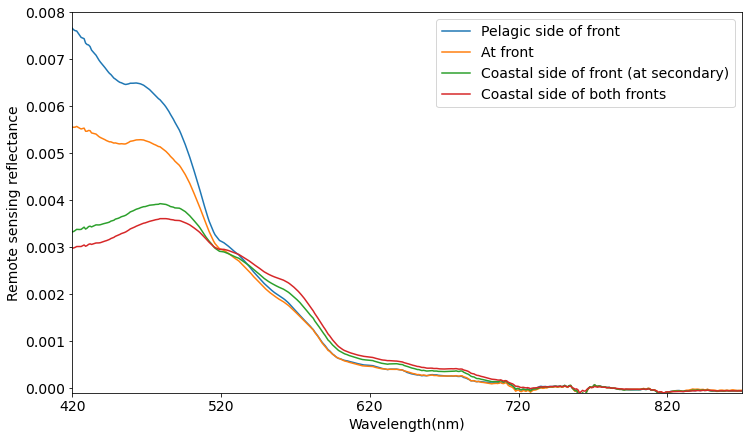

In [129]:
fig,ax = plt.subplots(figsize=(12,7))
corrected_specs.loc['2021-08-29 16:20:00':'2021-08-29 16:25:00'].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front')
corrected_specs.loc['2021-08-29 16:53:00':'2021-08-29 16:56:00'].median(numeric_only=True).iloc[:-5].plot(label='At front')
corrected_specs.loc['2021-08-29 17:15:00':'2021-08-29 17:20:00'].median(numeric_only=True).iloc[:-5].plot(label='Coastal side of front (at secondary)')
corrected_specs.loc['2021-08-29 17:40:00':'2021-08-29 17:45:00'].median(numeric_only=True).iloc[:-5].plot(label='Coastal side of both fronts')

# ax.axhline(0)
ax.set_xlim(100,550)
ax.set_ylim(-0.0001,0.008)
ax.set_xlabel('Wavelength(nm)')
ax.set_ylabel('Remote sensing reflectance')

ax.legend()
plt.savefig('figs/aug2916_radiometry_spectra.png')


In [229]:
trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T.mean(axis=1).shape

(631,)

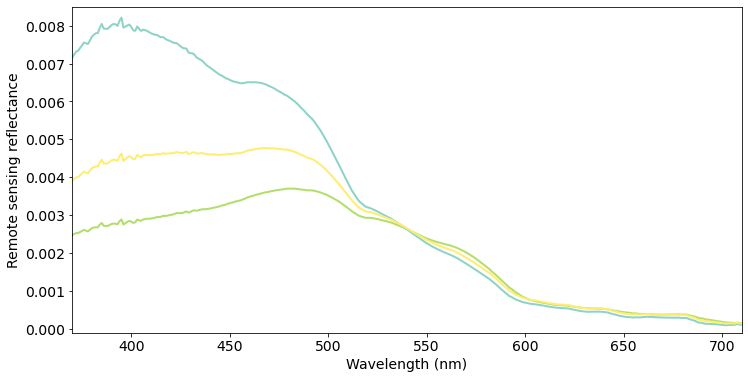

In [238]:
color_list = plt.cm.Set3(np.linspace(0, 1, 3))
color_list

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlim(370,710)
ax.set_ylim(-0.0001,0.0085)
# ax.axvline(120, c='k', ls='--')
# ax.axvline(535-125, c='k', ls='--')
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T,c=color_list[1], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T,c=color_list[0], alpha=.01)
# ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T,c=color_list[2], alpha=.01)

ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==0].iloc[:,:-7].values.T.mean(axis=1),c=color_list[1], alpha=1, lw=2)
ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==1].iloc[:,:-7].values.T.mean(axis=1),c=color_list[0], alpha=1, lw=2)
ax.plot(trios_subset.columns[:-7].astype(int), trios_subset[kmeans.labels_==2].iloc[:,:-7].values.T.mean(axis=1),c=color_list[2], alpha=1, lw=2)

# trios_subset[kmeans.labels_==0].iloc[:,:-8].plot(label='Pelagic side of front', ax=ax, c=color_list[1], lw=3)
# trios_subset[kmeans.labels_==1].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[0], lw=3)
# trios_subset[kmeans.labels_==2].median(numeric_only=True).iloc[:-5].plot(label='Pelagic side of front', ax=ax, c=color_list[2], lw=3)

ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel('Remote sensing reflectance')

fig.savefig('figs/aug2916_trios_clusters_spectra.png',dpi=300)

In [243]:
trios_subset['cluster'] = kmeans.labels_

/srv/conda/envs/notebook/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [245]:
trios_subset.to_csv('trios_clusters_spectra.csv')

In [242]:
trios_subset.shape

(344, 638)

In [46]:
lats = []
lons = []
sals = []
temps = []
for i in range(len(corrected_specs)):
    row = df.iloc[df.index.get_loc(pd.to_datetime(corrected_specs.iloc[i].TimeStamp) + timedelta(hours=4), method='nearest')]
    lats.append(row.lat)
    lons.append(row.lon)
    sals.append(row['TSG--sal'])
    temps.append(row['TSG--temp-SBE38'])

In [47]:
corrected_specs['lat'] = lats
corrected_specs['lon'] = lons
corrected_specs['sal'] = sals
corrected_specs['temp'] = temps

In [48]:
trios_gdf = gpd.GeoDataFrame(
    corrected_specs, geometry=gpd.points_from_xy(corrected_specs.lon, corrected_specs.lat))

<AxesSubplot:>

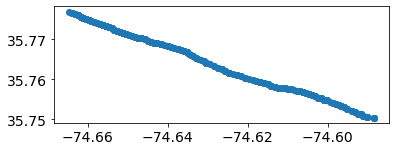

In [49]:
trios_gdf.plot()

In [50]:
trios_gdf.columns

Index(['320', '321', '322', '323', '324', '325', '326', '327', '328', '329',
       ...
       '948', '949', '950', 'chla_oci', 'TimeStamp', 'lat', 'lon', 'sal',
       'temp', 'geometry'],
      dtype='object', length=638)

In [51]:
chlci = trios_gdf.chla_oci.values

In [52]:
trios_gdf.iloc[:,1:-7]

321       322       323       324       325  \
2021-08-29 16:15:10  0.005342  0.005383  0.005333  0.005271  0.005224   
2021-08-29 16:15:20  0.005442  0.005458  0.005385  0.005306  0.005246   
2021-08-29 16:15:30  0.005799  0.005783  0.005705  0.005626  0.005566   
2021-08-29 16:15:40  0.005119  0.005142  0.005082  0.005014  0.004962   
2021-08-29 16:15:50  0.005650  0.005663  0.005593  0.005512  0.005448   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50  0.002661  0.002665  0.002617  0.002556  0.002509   
2021-08-29 17:51:00  0.002705  0.002704  0.002660  0.002607  0.002566   
2021-08-29 17:51:30  0.002004  0.002005  0.001965  0.001910  0.001868   
2021-08-29 17:51:40  0.001947  0.001940  0.001903  0.001852  0.001812   
2021-08-29 17:52:00  0.003927  0.003931  0.003873  0.003800  0.003741   

                          326       327       328       329       330  ...  \
2021-08-29 16:15:10  0.005256  0.005184  0.005047  0.005116  0.005195  ...   
2021-08-29 16:15:20  0.005269  0.005190  0.005048  0.005126  0.005227  ...   
2021-08-29 16:15:30  0.005592  0.005506  0.005350  0.005413  0.005506  ...   
2021-08-29 16:15:40  0.004985  0.004908  0.004768  0.004834  0.004930  ...   
2021-08-29 16:15:50  0.005473  0.005402  0.005266  0.005329  0.005418  ...   
...                       ...       ...       ...       ...       ...  ...   
2021-08-29 17:50:50  0.002511  0.002439  0.002323  0.002358  0.002402  ...   
2021-08-29 17:51:00  0.002573  0.002503  0.002389  0.002424  0.002466  ...   
2021-08-29 17:51:30  0.001874  0.001801  0.001684  0.001718  0.001763  ...   
2021-08-29 17:51:40  0.001813  0.001745  0.001639  0.001675  0.001718  ...   
2021-08-29 17:52:00  0.003741  0.003657  0.003523  0.003552  0.003590  ...   

                          941       942       943       944       945  \
2021-08-29 16:15:10 -0.000420 -0.000468 -0.000381 -0.000260 -0.000141   
2021-08-29 16:15:20 -0.000469 -0.000600 -0.000486 -0.000381 -0.000276   
2021-08-29 16:15:30 -0.000533 -0.000585 -0.000709 -0.000770 -0.000830   
2021-08-29 16:15:40 -0.000616 -0.000581 -0.000557 -0.000587 -0.000618   
2021-08-29 16:15:50 -0.001112 -0.001083 -0.000967 -0.000850 -0.000734   
...                       ...       ...       ...       ...       ...   
2021-08-29 17:50:50 -0.000287 -0.000253 -0.000283 -0.000298 -0.000314   
2021-08-29 17:51:00 -0.000282 -0.000342 -0.000362 -0.000335 -0.000305   
2021-08-29 17:51:30 -0.000152 -0.000184 -0.000176 -0.000126 -0.000076   
2021-08-29 17:51:40 -0.000132 -0.000139 -0.000095 -0.000079 -0.000066   
2021-08-29 17:52:00 -0.000412 -0.000416 -0.000482 -0.000547 -0.000610   

                          946       947       948       949       950  
2021-08-29 16:15:10 -0.000235 -0.000450 -0.000701 -0.000786 -0.000749  
2021-08-29 16:15:20 -0.000403 -0.000530 -0.000644 -0.000569 -0.000461  
2021-08-29 16:15:30 -0.000726 -0.000702 -0.000719 -0.000709 -0.000649  
2021-08-29 16:15:40 -0.000626 -0.000626 -0.000623 -0.000551 -0.000451  
2021-08-29 16:15:50 -0.000690 -0.000659 -0.000629 -0.000651 -0.000712  
...                       ...       ...       ...       ...       ...  
2021-08-29 17:50:50 -0.000306 -0.000312 -0.000325 -0.000320 -0.000317  
2021-08-29 17:51:00 -0.000286 -0.000274 -0.000263 -0.000257 -0.000262  
2021-08-29 17:51:30 -0.000028 -0.000013 -0.000011 -0.000038 -0.000071  
2021-08-29 17:51:40 -0.000023  0.000010  0.000035 -0.000018 -0.000100  
2021-08-29 17:52:00 -0.000582 -0.000555 -0.000535 -0.000498 -0.000461  

[344 rows x 630 columns]

In [53]:
chlci[chlci>.5] = .5

(0.1, 0.4)

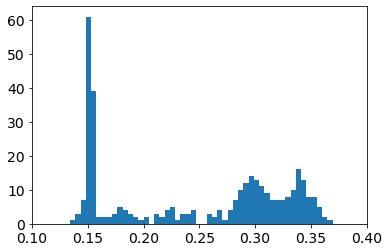

In [54]:
plt.hist(chlci, bins=50)
plt.xlim(0.1,.4)

Run some clustering

In [55]:
trios_gdf.columns[1:-7]

Index(['321', '322', '323', '324', '325', '326', '327', '328', '329', '330',
       ...
       '941', '942', '943', '944', '945', '946', '947', '948', '949', '950'],
      dtype='object', length=630)

In [56]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(trios_gdf.values[:,1:-7])

In [57]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([ 18,  95, 109,  38,  84]))

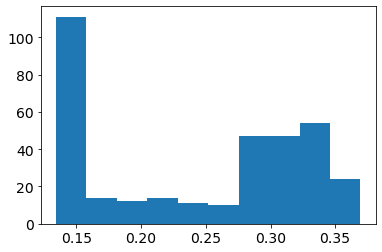

In [58]:
plt.hist(trios_gdf.chla_oci)
plt.show()

Text(0.5, 1.0, 'August 27th Trios Radiometer based Chla')

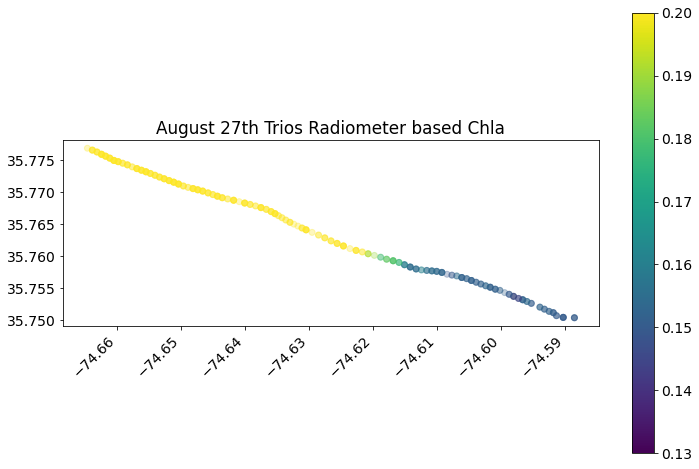

In [59]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(trios_gdf.values[:,1:-7])
fig, ax = plt.subplots(figsize=(12,9))
sc = trios_gdf.plot('chla_oci', ax=ax, vmin=.13,vmax=.20, cmap='viridis', alpha=0.3, label='CI Chla', legend=True)
# ss = ax.scatter(trios_gdf.lon, trios_gdf.lat, c=trios_gdf.chl, s=100)
# fig.colorbar(sc,ax=ax)
# fig.colorbar(sc, ax=ax)
fig.autofmt_xdate(rotation=45)
ax.set_title('August 27th Trios Radiometer based Chla')
# fig.savefig('trios_radiometers_chlaci.png')

<AxesSubplot:>

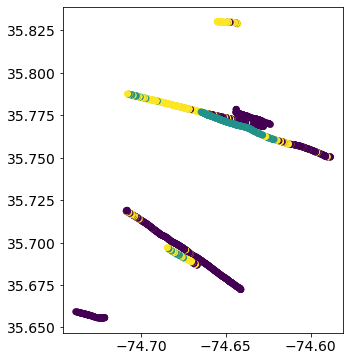

In [134]:
fig, ax = plt.subplots(figsize=(8,6))
trios_gdf.plot(c=kmeans.labels_,ax=ax)

In [135]:
trios_gdf_transect = trios_gdf#.loc['2021-08-27 16:15:00':'2021-08-27 17:30:00']

In [219]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-7]

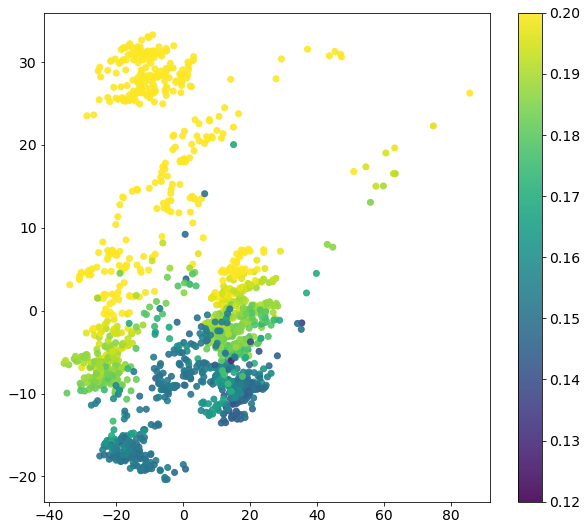

In [220]:
x = trios_gdf_transect.rolling(window=6).mean().values[:,1:-7]
x = x[12:,:]
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)

In [221]:
from sklearn.preprocessing import StandardScaler
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [222]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [140]:
principalComponents.shape

(1544, 2)

<AxesSubplot:>

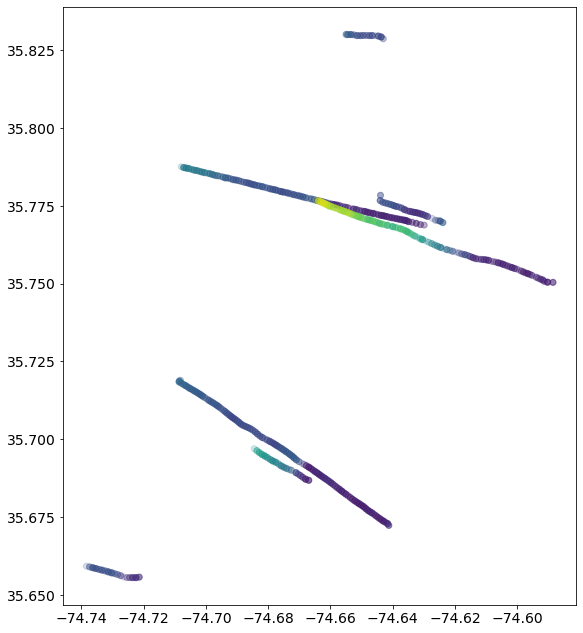

In [141]:
fig, ax = plt.subplots(figsize=(14,11))
trios_gdf_transect.iloc[12:].plot(c=trios_gdf_transect.iloc[12:].chla_oci,ax=ax, alpha=0.2, vmin=0.2, vmax=.24)
# fig.savefig('chla_transect.png')

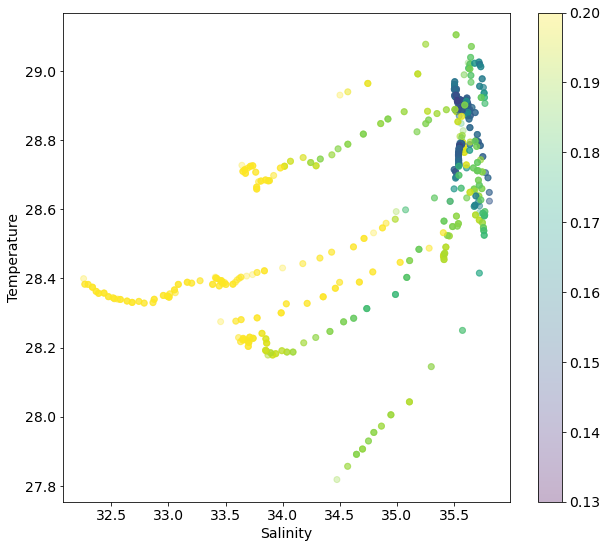

In [144]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['sal'].iloc[12:], trios_gdf_transect['temp'].iloc[12:], alpha=0.3, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.13,vmax=.20, cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

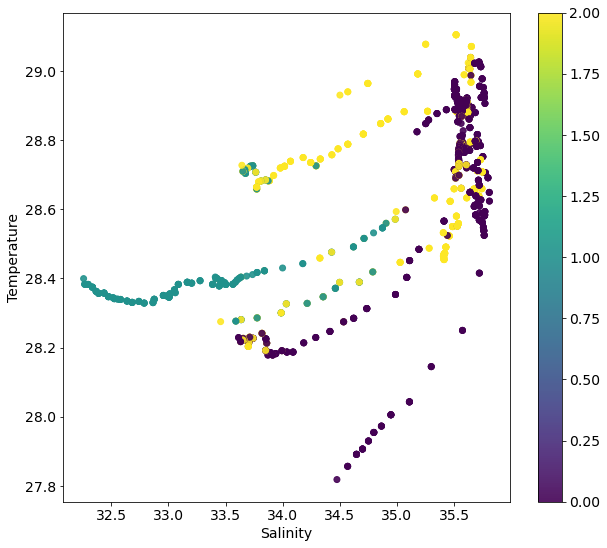

In [145]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['sal'].iloc[12:], trios_gdf_transect['temp'].iloc[12:], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')

ax.set_xlabel("Salinity")
ax.set_ylabel("Temperature")


fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

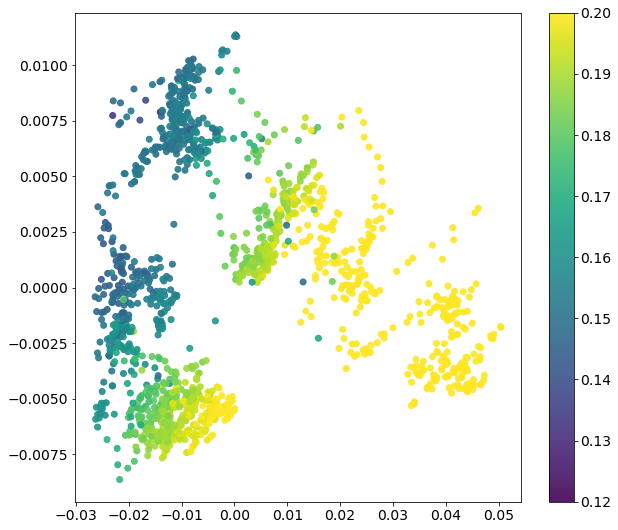

In [190]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

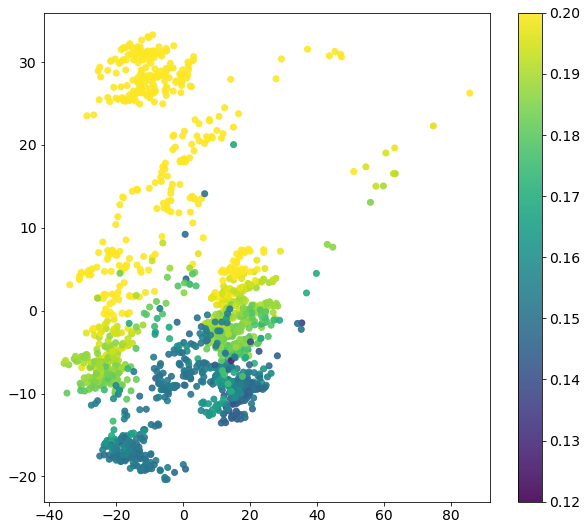

In [146]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

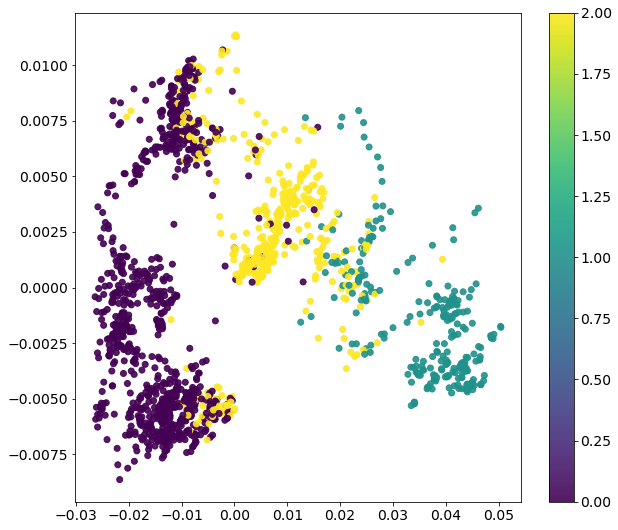

In [193]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

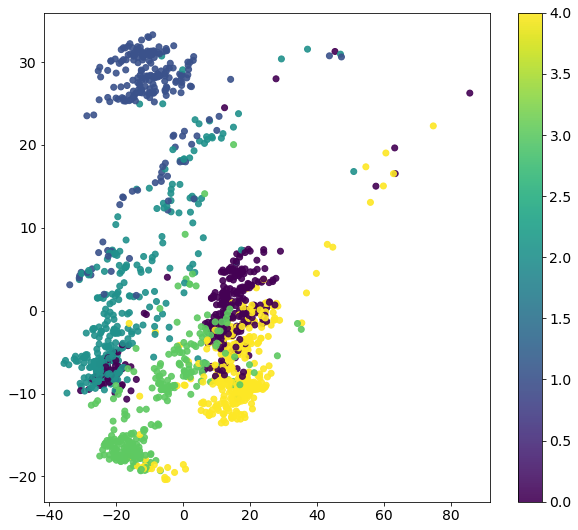

In [223]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

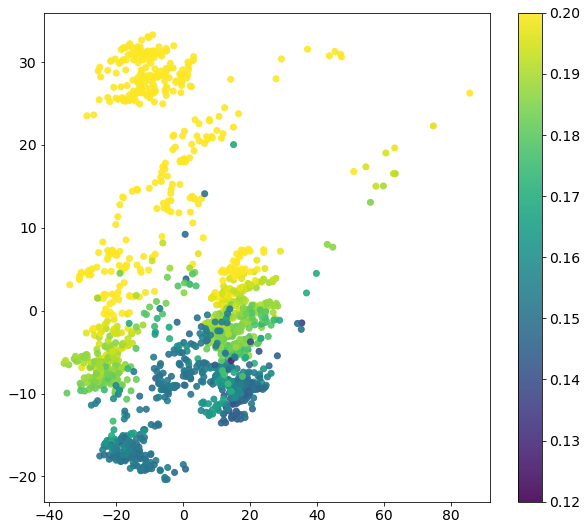

In [148]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(principalComponents[:,0], principalComponents[:,1], alpha=0.9, c=trios_gdf_transect['chla_oci'].iloc[12:], vmin=.12,vmax=.20, cmap='viridis', label='chla')
fig.colorbar(sc)
# ax.set_ylim(-3,2)
# ax.set_xlim(-6,8)
# fig.savefig('pca_transect.png')

In [149]:
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=5, random_state=0).fit(x)
# np.unique(kmeans.labels_, return_counts=True)

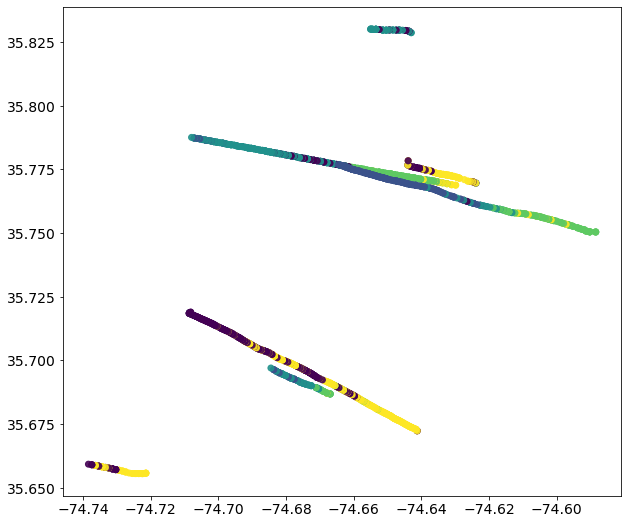

In [215]:
fig, ax = plt.subplots(figsize=(10,9))
sc = ax.scatter(trios_gdf_transect['lon'].iloc[12:], trios_gdf_transect['lat'].iloc[12:], alpha=0.9, c=kmeans.labels_[12:], cmap='viridis', label='chla')

ValueError: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 1,
       1, 2, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2,
       2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 2,
       2, 0, 2, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 2, 0,
       2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], dtype=int32) is not a valid value for color

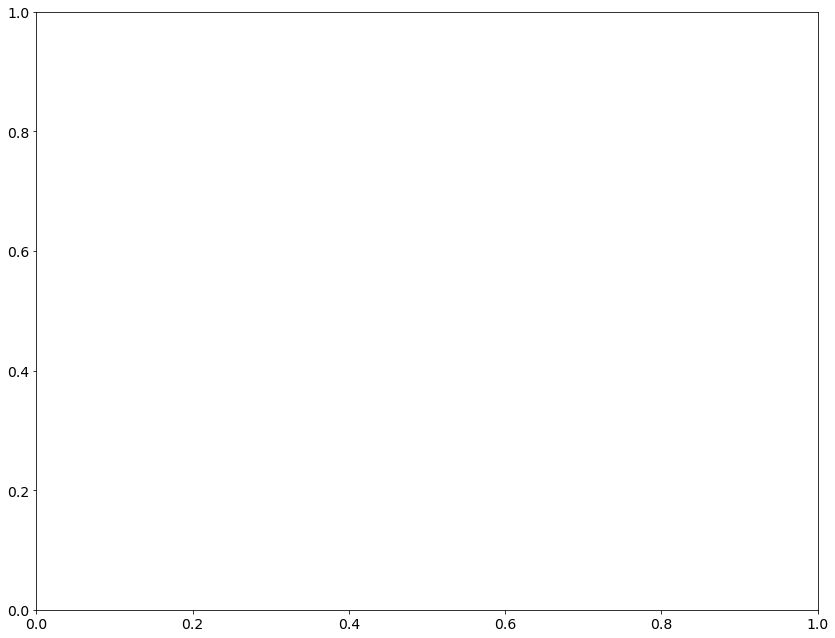

In [209]:
fig, ax = plt.subplots(figsize=(14,11))
ax.plot(trios_gdf_transect.iloc[12:].lon,trios_gdf_transect.iloc[12:].lon,c=kmeans.labels_,ax=ax, alpha=0.2, cmap='Set1')`a


In [151]:
len(x), len(kmeans.labels_[12:])

(1544, 1544)

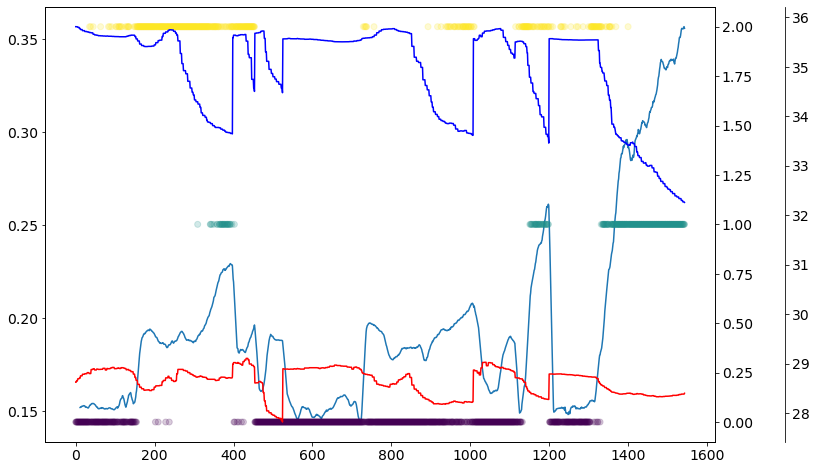

In [152]:
fig, ax  =plt.subplots(figsize=(12,8))
ax.plot(np.arange(0,len(x)),trios_gdf_transect.chla_oci.iloc[12:].rolling(window=12).mean())

ax2=ax.twinx()
ax2.scatter(np.arange(0,len(x)), kmeans.labels_[12:], alpha=0.2, c=kmeans.labels_[12:])

ax3 = ax.twinx()
ax3.plot(np.arange(0,len(x)),trios_gdf_transect['sal'].iloc[12:], color='blue')
ax3.plot(np.arange(0,len(x)),trios_gdf_transect['temp'].iloc[12:], color='red')
ax3.spines['right'].set_position(('outward', 70))

# fig.savefig('cluster_chla.png')